In [1]:
'''This salary prediction model pulls job data and predicts salaries across multiple models. 
    It then saves the model and produces a prediction file.'''

'This salary prediction model pulls job data and predicts salaries across multiple models. \n    It then saves the model and produces a prediction file.'

In [1]:
__author__ = "Khalid Rahman"
__email__ = "kirahman2@gmail.com"

### Import packages

In [11]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import time
import pickle
import os

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Defining Data class

In [13]:
class Data:
    def __init__(self, train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target):
        '''create train and test dataframes'''
        self.col_cat = col_cat
        self.col_num = col_num
        self.col_all = col_cat + col_num
        self.col_id = col_id
        self.col_target = col_target
        self.train_eda = pd.DataFrame()
        self.train_raw = pd.DataFrame()
        self.test_raw = pd.DataFrame()
        self.train_df = self._create_train_df(train_file, train_target_file)
        self.test_df = self._create_test_df(test_file)
        
    def _create_train_df(self, train_df, train_target):
        '''create train dataframe'''
        target = self._load_file(train_target)
        df = self._load_file(train_df)
        df = self._join_df(df, target, self.col_id)
        df = self._correct_data(df)
        self.train_eda = df
        df = self._clean_data(df)
        df = self._shuffle_data(df)
        self.train_raw = df
        df = self._label_encode(df, self.col_cat)
        return df
    
    def _create_test_df(self, test_file):
        '''create test dataframe'''
        df = self._load_file(test_file)
        df = self._correct_data(df)
        self.test_raw = df
        df = self._label_encode(df, self.col_cat)
        return df

    def _shuffle_data(self, df):
        '''shuffling data'''
        return shuffle(df, random_state=42).reset_index(drop=True)

    def _clean_data(self, df):
        '''remove outliers from data'''
        return df[(df.salary>8) & (df.salary<220)]
    
    def _correct_data(self,df):
        '''correcting data values'''
        list_index = df[ (df['degree']!='HIGH_SCHOOL')
                       & (df['degree']!='NONE') 
                       & (df['major']=='NONE')
                       ].index
        df.loc[list_index,'major'] = 'MISSING'
        return df
    
    def _label_encode(self, df, col_cat):
        '''label encode dataframes'''
        le = LabelEncoder()
        for col in col_cat:
            df[col] = le.fit_transform(df[col])
        return df
         
    def _join_df(self, train_df, train_target, col_id):
        '''join train and target dataframes'''
        return pd.merge(train_df, train_target, on=col_id, how='inner')

    def _load_file(self, file):
        '''load files'''
        return pd.read_csv(file)

### Defining Feature Engineering class

In [14]:
class FeatureEngineering:
    def __init__(self, train_raw, train_df, test_raw, test_df, col_cat, target, col_id):
        '''create train and test dataframes'''
        df_temp = pd.DataFrame()
        self.train_df = train_df
        self.train_raw = train_raw
        self.test_df = test_df
        self.test_raw = test_raw
        self._groupby(self.train_raw, train_df, self.test_raw, col_cat, target)
    
    def _groupby(self, train_raw, train_df, test_raw, col_cat, col_target):
        '''parse through each categorical column and compute mean of each unique value'''
        for i in range(0, len(col_cat)):
            df_temp = self._compute_mean(train_raw, col_cat, i, col_target)
            list_col_temp = df_temp[col_cat[i]]
            list_col_target = df_temp[col_target]
            dict_temp = self._create_dictionary(df_temp, list_col_temp, list_col_target)
            data.train_df[col_cat[i] +'_mean'] = self._map_dictionary(train_raw, col_cat, i, dict_temp)
            data.test_df[col_cat[i] +'_mean'] = self._map_dictionary(test_raw, col_cat, i, dict_temp)
            self._append_columns(train_df, col_cat, i)
        data.col_all = data.col_cat + data.col_num
    
    def _compute_mean(self, train_raw, col_cat, i, col_target):
        '''compute mean of unique categorical values'''
        return train_raw.groupby(col_cat[i])[col_target].mean().sort_values(ascending=True).reset_index()
        
    def _create_dictionary(self, df_temp, list_col_temp, list_col_target):
        '''create dictionary of unique categorical values and mean salary values'''
        dict_temp = {}
        for j in range(0,len(df_temp)):
            dict_temp.update([(list_col_temp[j], list_col_target[j])]) 
        return dict_temp
    
    def _map_dictionary(self, df_eda, col_cat, i, dict_temp):
        '''mapping dictionary values'''
        return df_eda[col_cat[i]].map(dict_temp)
    
    def _append_columns(self, train_df, col_cat, i):
        '''appending new column names to col_num list'''
        data.col_num.append(train_df[col_cat[i] +'_mean'].name)

### Defining Model class

In [16]:
class Model:
    def __init__(self, train_features, train_target, model_container, set_cv, num_proc, dir_pred):
        '''create train dataframe'''
        self.train_df = train_features
        self.target = train_target
        self.filename = 'best_model.sav'
    
    def add_model(self, model):
        '''add new model'''
        model_container[model] = self._score_model(model, self.train_df, 
                                                   self.target, set_cv, num_proc)
        pass_temp = model_container[model]
        self._model_summary(model, pass_temp)
    
    def _model_summary(self, model, pass_temp):
        print(model)
        print('score:', model_container[model],'\n')        
        
    def fit_model(self, model, train_df, target):
        '''fit model'''
        return model.fit(train_df, target)
        
    def predict_model(self, model_selected, test_df, train_df, target, save_best_model):
        '''predict and store best model'''
        model = self.fit_model(model_selected, train_df, target)
        self._save_model(model, self.filename, save_best_model)
        prediction_results = model.predict(test_df)
        self._save_prediction(prediction_results)
        return prediction_results

    def _important_features(self, model):
        '''create feature importance dataframe'''
        if hasattr(model,'feature_importances_'):
            col_feat_rank = pd.DataFrame(model.feature_importances_, columns=['score'])
            col_feat = pd.DataFrame(data.col_all, columns=['feature'])
            df_feat = pd.concat([col_feat,col_feat_rank],axis=1).sort_values('score',ascending=False).reset_index(drop=True)
            print('\n', model)
            print("\nFeature Importances\n", df_feat)
            self._feature_barplot(df_feat)
        else:
            return print("\nModel does not have feature_importances_ attribute.")

    def _feature_barplot(self, df):
        '''create feature importance barplot'''
        sns.barplot(df.score,df.feature, palette='Blues_d', fontsize=14).set_title('Feature Importances', fontsize=16)
        
    def best_scoring_model(self, model_container):
        '''select best scoring model'''
        best_model = min(model_container, key=model_container.get)
        best_score = model_container.get(best_model)
        self._best_model_summary(best_model, best_score)
        return best_model
    
    def _best_model_summary(self, best_model, best_score):
        '''print summary results of best model'''
        print('The best model is:\n', best_model)
        print('\nThe best score is:\n', best_score)
        
    def load_model(self, load_best_model, test_df):
        '''load best model and call feature importance'''
        if load_best_model:
            # figure out how to 
            print('\nLoading saved best model...')
            loading_best_model = joblib.load(self.filename)
            self._important_features(loading_best_model)
            model_pred = loading_best_model.predict(test_df)
        else:
            print('\nNo prediction file was created because load_best_model is set to false.')

#     def model:
#         '''save best model'''
#         if save_best_model:
#             pickle.dump(model, open(filename, 'wb'))
#             print('The model has been saved.')
#         else:
#             print('\nThe best performing model was not saved because save_best_model is set to false.')
        
    def _score_model(self, model, train_df, target_train, set_cv, num_proc):
        '''score model'''
        return -1.0*np.mean(cross_val_score(model, train_df, target_train, scoring='neg_mean_squared_error', cv=set_cv, n_jobs=num_proc))

    def _save_prediction(self, prediction_results):
        '''save predictions as csv file'''
        prediction_results = pd.DataFrame(prediction_results).to_csv(dir_pred)

### Defining parameters to run model

In [17]:
train_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_features.csv'
test_file = '/Users/krahman/work/salarypredictionportfolio_old/data/test_features.csv'
train_target_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_salaries.csv'
col_cat = ['companyId', 'jobType', 'degree', 'major', 'industry']
col_num = ['milesFromMetropolis', 'yearsExperience']
col_all = col_cat + col_num
col_id = 'jobId'
col_target = 'salary'

set_cv = 2
num_proc = -1
save_best_model = False
load_best_model = True
dir_pred = '/Users/krahman/work/salarypredictionportfolio/predictions/test_salaries.csv'
model_container = {}

### Create data object

In [18]:
data = Data(train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target)

### Create feature engineering object

In [19]:
fe = FeatureEngineering(data.train_raw, data.train_df, data.test_raw, 
                        data.test_df, data.col_cat, data.col_target, col_id)

### Finalize training, target and test dataframes for our model

In [20]:
train_features = data.train_df[data.col_all]
train_target = data.train_df[col_target]
test_features = data.test_df[data.col_all]

###
# train_features = data.train_df.loc[:1000,:]
# train_target = data.train_df.loc[:1000,:]
# test_features = data.test_df.loc[:1000,:]
# train_features = train_features[data.col_all]
# train_target = train_target[col_target]
# test_features = test_features[data.col_all]
###

### Create model object

In [21]:
model = Model(train_features, train_target, model_container, set_cv, num_proc, dir_pred)

In [22]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# data.train_df

### Tune model parameters

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data.train_df.drop([col_target,col_id],axis=1), data.train_df[col_target], test_size=0.25)

In [24]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data.train_df.drop([col_target,col_id],axis=1), data.train_df[col_target], test_size=0.25)

In [26]:
###### GBR Tuning ######
# COMPLETE
# best loss=['ls', 'huber']
results = []
list_values = ['ls', 'lad', 'huber', 'quantile']
hyperp = 'loss'
for val in list_values:
    gbr = GradientBoostingRegressor(loss=val, verbose=False)
    gbr.fit(X_train, y_train)
    results.append(
    {'loss': val,
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# gbr +maxdepth COMPLETE
# best max_depth=[]                                                  ###
hyperp = 'max_depth'                                                 ###
list_val = range(1,13,3)

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(max_depth=val, loss='huber',           ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

  loss  train_error  test_error  minutes
0   ls   308.593133  346.113112  91.0497
  loss  train_error  test_error    minutes
0   ls   308.593133  346.113112  91.049700
1  lad   317.417978  347.697251  76.225045
    loss  train_error  test_error    minutes
0     ls   308.593133  346.113112  91.049700
1    lad   317.417978  347.697251  76.225045
2  huber   308.950998  346.729243  61.788061
       loss  train_error  test_error    minutes
0        ls   308.593133  346.113112  91.049700
1       lad   317.417978  347.697251  76.225045
2     huber   308.950998  346.729243  61.788061
3  quantile   923.792186  941.609042  51.474482


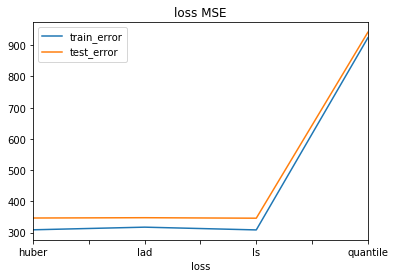

In [34]:
# gbr +maxdepth COMPLETE
# best loss=['huber']                                                  ###
hyperp = 'loss'                                                 ###
list_val = ['ls', 'lad', 'huber', 'quantile']

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(loss=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

0.6
   learning_rate  train_error  test_error
0            0.6   345.287172  346.974587
0.7
   learning_rate  train_error  test_error
0            0.6   345.287172  346.974587
1            0.7   345.664155  347.256681
0.8
   learning_rate  train_error  test_error
0            0.6   345.287172  346.974587
1            0.7   345.664155  347.256681
2            0.8   346.491820  347.774154
0.9
   learning_rate  train_error  test_error
0            0.6   345.287172  346.974587
1            0.7   345.664155  347.256681
2            0.8   346.491820  347.774154
3            0.9   348.228780  349.743875


,train_error,test_error
learning_rate,,
0.6,345.287172,346.974587
0.7,345.664155,347.256681
0.8,346.491820,347.774154
0.9,348.228780,349.743875


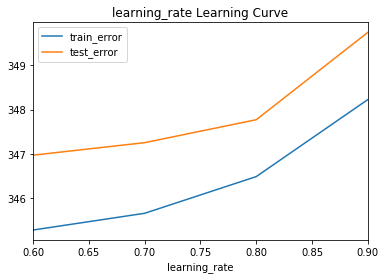

In [230]:
# COMPLETE
# best learning_rate= [.5,.6,.7]
results = []
list_values = [1e-1,1e-2,1e-3,1e-4,1e-5]
list_values = [.6,.7,.8,.9]
# list_values = [1e-1,1e-2,1e-3]
hyperp = 'learning_rate'
for val in list_values:
    gbr = GradientBoostingRegressor(learning_rate=val, verbose=False, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'learning_rate': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

0.1
   learning_rate  train_error  test_error
0            0.1   350.378303  351.876126
0.2
   learning_rate  train_error  test_error
0            0.1   350.378303  351.876126
1            0.2   349.888022  351.554097
0.3
   learning_rate  train_error  test_error
0            0.1   350.378303  351.876126
1            0.2   349.888022  351.554097
2            0.3   348.993112  350.591193
0.4
   learning_rate  train_error  test_error
0            0.1   350.378303  351.876126
1            0.2   349.888022  351.554097
2            0.3   348.993112  350.591193
3            0.4   349.277074  350.788066
0.5
   learning_rate  train_error  test_error
0            0.1   350.378303  351.876126
1            0.2   349.888022  351.554097
2            0.3   348.993112  350.591193
3            0.4   349.277074  350.788066
4            0.5   346.228892  347.837787


,train_error,test_error
learning_rate,,
0.1,350.378303,351.876126
0.2,349.888022,351.554097
0.3,348.993112,350.591193
0.4,349.277074,350.788066
0.5,346.228892,347.837787


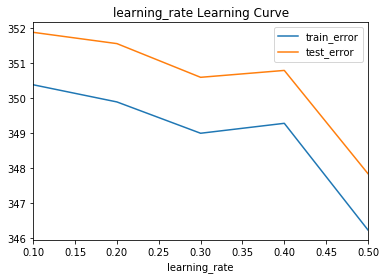

In [227]:
# COMPLETE
# best learning_rate = [.5,.6,.7]
results = []
list_values = [1e-1,1e-2,1e-3,1e-4,1e-5]
list_values = [.1,.2,.3,.4,.5]
# list_values = [1e-1,1e-2,1e-3]
hyperp = 'learning_rate'
for val in list_values:
    gbr = GradientBoostingRegressor(learning_rate=val, verbose=False, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'learning_rate': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# gbr +maxdepth 
# best learning_rate=                                                    ###
hyperp = 'learning_rate'                                                 ###
list_val = [.01,.05,.1,.2,.5,.9]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(learning_rate=val, max_depth=10, loss='huber',          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

   learning_rate  train_error   test_error   minutes
0           0.01   2264.03993  2277.417033  4.985321
   learning_rate  train_error   test_error   minutes
0           0.01  2264.039930  2277.417033  4.985321
1           0.03   365.872372   379.958446  7.353881
   learning_rate  train_error   test_error   minutes
0           0.01  2264.039930  2277.417033  4.985321
1           0.03   365.872372   379.958446  7.353881
2           0.05   324.367533   344.859675  6.940973
   learning_rate  train_error   test_error   minutes
0           0.01  2264.039930  2277.417033  4.985321
1           0.03   365.872372   379.958446  7.353881
2           0.05   324.367533   344.859675  6.940973
3           0.07   317.644343   343.997674  6.271013
   learning_rate  train_error   test_error   minutes
0           0.01  2264.039930  2277.417033  4.985321
1           0.03   365.872372   379.958446  7.353881
2           0.05   324.367533   344.859675  6.940973
3           0.07   317.644343   343.997674  6.

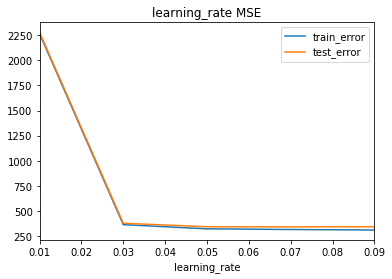

In [37]:
# gbr +maxdepth
# best learning_rate=[.05,.07,.09]                                                    ###
hyperp = 'learning_rate'                                                 ###
list_val = [.01,.03,.05,.07,.09]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(learning_rate=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

103
   n_estimators  train_error  test_error
0           103   350.044901  351.530963
105
   n_estimators  train_error  test_error
0           103   350.044901  351.530963
1           105   349.899917  351.377790
107
   n_estimators  train_error  test_error
0           103   350.044901  351.530963
1           105   349.899917  351.377790
2           107   349.696421  351.171306
109
   n_estimators  train_error  test_error
0           103   350.044901  351.530963
1           105   349.899917  351.377790
2           107   349.696421  351.171306
3           109   349.570132  351.036576
111
   n_estimators  train_error  test_error
0           103   350.044901  351.530963
1           105   349.899917  351.377790
2           107   349.696421  351.171306
3           109   349.570132  351.036576
4           111   349.464413  350.925611


,train_error,test_error
n_estimators,,
103,350.044901,351.530963
105,349.899917,351.377790
107,349.696421,351.171306
109,349.570132,351.036576
111,349.464413,350.925611


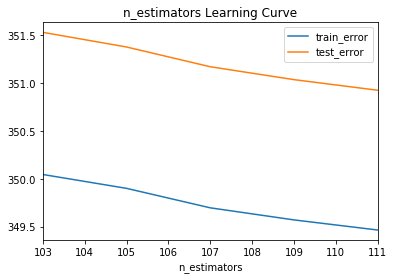

In [236]:
# COMPLETE
# best n_estimators= [110,111,112]
# Just beat 340
results = []
list_values = range(103,112,2)
hyperp = 'n_estimators'                                           ###
for val in list_values:
    gbr = GradientBoostingRegressor(n_estimators=val, verbose=False, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'n_estimators': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

70
   n_estimators  train_error  test_error
0            70   356.635749  358.326751
80
   n_estimators  train_error  test_error
0            70   356.635749  358.326751
1            80   353.509754  355.116768
90
   n_estimators  train_error  test_error
0            70   356.635749  358.326751
1            80   353.509754  355.116768
2            90   351.640269  353.183291
100
   n_estimators  train_error  test_error
0            70   356.635749  358.326751
1            80   353.509754  355.116768
2            90   351.640269  353.183291
3           100   350.378303  351.876126
110
   n_estimators  train_error  test_error
0            70   356.635749  358.326751
1            80   353.509754  355.116768
2            90   351.640269  353.183291
3           100   350.378303  351.876126
4           110   349.522397  350.986633
120
   n_estimators  train_error  test_error
0            70   356.635749  358.326751
1            80   353.509754  355.116768
2            90   351.640269  353.18

,train_error,test_error
n_estimators,,
70,356.635749,358.326751
80,353.509754,355.116768
90,351.640269,353.183291
100,350.378303,351.876126
110,349.522397,350.986633
120,348.896333,350.339155
130,348.434715,349.872262
140,348.073994,349.496206


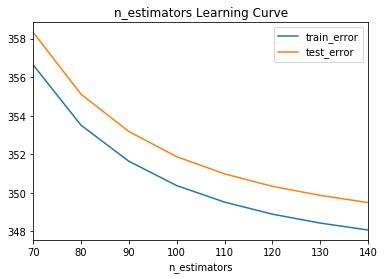

In [241]:
# COMPLETE
# best n_estimators=[110,111,112]
# Just beat 340
results = []
list_values = range(70,150,10)
hyperp = 'n_estimators'                                           ###
for val in list_values:
    gbr = GradientBoostingRegressor(n_estimators=val, verbose=False, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'n_estimators': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

0.78
   subsample  train_error  test_error
0       0.78   350.616531  352.212039
0.79
   subsample  train_error  test_error
0       0.78   350.616531  352.212039
1       0.79   349.882546  351.568533
0.8
   subsample  train_error  test_error
0       0.78   350.616531  352.212039
1       0.79   349.882546  351.568533
2       0.80   350.196239  351.734352
0.81
   subsample  train_error  test_error
0       0.78   350.616531  352.212039
1       0.79   349.882546  351.568533
2       0.80   350.196239  351.734352
3       0.81   349.961490  351.594613
0.82
   subsample  train_error  test_error
0       0.78   350.616531  352.212039
1       0.79   349.882546  351.568533
2       0.80   350.196239  351.734352
3       0.81   349.961490  351.594613
4       0.82   350.043608  351.614076
0.83
   subsample  train_error  test_error
0       0.78   350.616531  352.212039
1       0.79   349.882546  351.568533
2       0.80   350.196239  351.734352
3       0.81   349.961490  351.594613
4       0.82   350.04

,train_error,test_error
subsample,,
0.78,350.616531,352.212039
0.79,349.882546,351.568533
0.80,350.196239,351.734352
0.81,349.961490,351.594613
0.82,350.043608,351.614076
0.83,350.175842,351.698941
0.84,349.824492,351.494086
0.85,350.571037,352.084694


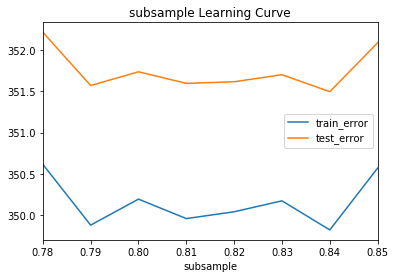

In [233]:
# COMPLETE GBR
# best subsample= [.83,.84,.85]

results = []
list_values = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
list_values = [.78,.79,.8,.81,.82,.83,.84,.85]

hyperp = 'subsample'                                           ###
for val in list_values:
    gbr = GradientBoostingRegressor(subsample=val, verbose=0, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'subsample': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

   subsample  train_error  test_error  minutes
0        0.1   327.156707  354.743904  5.31503
   subsample  train_error  test_error   minutes
0        0.1   327.156707  354.743904  5.315030
1        0.3   315.041514  347.744080  4.033568
   subsample  train_error  test_error   minutes
0        0.1   327.156707  354.743904  5.315030
1        0.3   315.041514  347.744080  4.033568
2        0.5   311.684108  346.096649  4.537725
   subsample  train_error  test_error   minutes
0        0.1   327.156707  354.743904  5.315030
1        0.3   315.041514  347.744080  4.033568
2        0.5   311.684108  346.096649  4.537725
3        0.7   309.763438  345.376935  4.438166
   subsample  train_error  test_error   minutes
0        0.1   327.156707  354.743904  5.315030
1        0.3   315.041514  347.744080  4.033568
2        0.5   311.684108  346.096649  4.537725
3        0.7   309.763438  345.376935  4.438166
4        1.0   310.385331  344.922720  4.231141


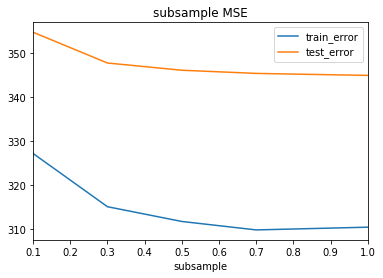

In [27]:
# gbr +maxdepth COMPLETEF
# best subsample=default                                                   ###
hyperp = 'subsample'                                                 ###
list_val = [.1,.3,.5,.7,1]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(subsample=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

   subsample  train_error  test_error   minutes
0        0.8   309.615295   345.29698  4.786216
   subsample  train_error  test_error   minutes
0        0.8   309.615295  345.296980  4.786216
1        0.9   309.254628  345.051713  5.809360


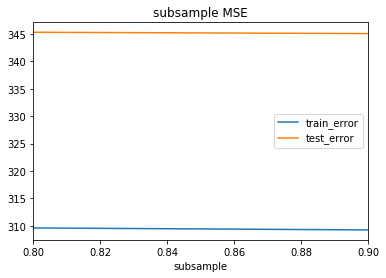

In [38]:
# gbr +maxdepth 
# best subsample=default                                                   ###
hyperp = 'subsample'                                                 ###
list_val = [.8,.9]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(subsample=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

friedman_mse
      criterion  train_error  test_error
0  friedman_mse   350.378303  351.876126
mse
      criterion  train_error  test_error
0  friedman_mse   350.378303  351.876126
1           mse   350.378303  351.876126


,train_error,test_error
criterion,,
friedman_mse,350.378303,351.876126
mse,350.378303,351.876126


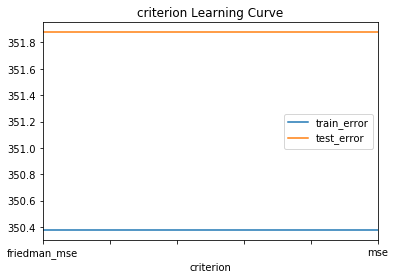

In [237]:
# COMPLETE
# best criterion= #exclude                                            ###
results = []
list_values = ['friedman_mse', 'mse']
hyperp = 'criterion'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(criterion=val, verbose=0, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'criterion': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

2
   min_samples_split  train_error  test_error
0                  2   350.378303  351.876126
102
   min_samples_split  train_error  test_error
0                  2   350.378303  351.876126
1                102   350.378303  351.876126
202
   min_samples_split  train_error  test_error
0                  2   350.378303  351.876126
1                102   350.378303  351.876126
2                202   350.378303  351.876126
302
   min_samples_split  train_error  test_error
0                  2   350.378303  351.876126
1                102   350.378303  351.876126
2                202   350.378303  351.876126
3                302   350.378303  351.876126
402
   min_samples_split  train_error  test_error
0                  2   350.378303  351.876126
1                102   350.378303  351.876126
2                202   350.378303  351.876126
3                302   350.378303  351.876126
4                402   350.378303  351.876126
502
   min_samples_split  train_error  test_error
0           

,train_error,test_error
min_samples_split,,
2,350.378303,351.876126
102,350.378303,351.876126
202,350.378303,351.876126
302,350.378303,351.876126
402,350.378303,351.876126
502,350.378303,351.876126
602,350.378303,351.876126
702,350.378303,351.876126
802,350.378303,351.876126


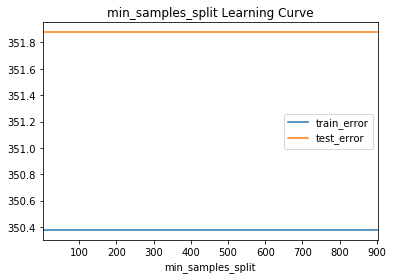

In [240]:
# COMPLETE
# best min_samples_split= exclude                                          ###
results = []
list_values = range(2,1002,100)
hyperp = 'min_samples_split'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_samples_split=val, verbose=0, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_samples_split': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

   min_samples_split  train_error  test_error   minutes
0                  2   310.385331   344.92272  4.130651
   min_samples_split  train_error  test_error   minutes
0                  2   310.385331   344.92272  4.130651
1                  5   310.385331   344.92272  4.124844
   min_samples_split  train_error  test_error   minutes
0                  2   310.385331   344.92272  4.130651
1                  5   310.385331   344.92272  4.124844
2                  8   310.385331   344.92272  4.202318
   min_samples_split  train_error  test_error   minutes
0                  2   310.385331   344.92272  4.130651
1                  5   310.385331   344.92272  4.124844
2                  8   310.385331   344.92272  4.202318
3                 11   310.385331   344.92272  4.132120
   min_samples_split  train_error  test_error   minutes
0                  2   310.385331   344.92272  4.130651
1                  5   310.385331   344.92272  4.124844
2                  8   310.385331   344.92272  4

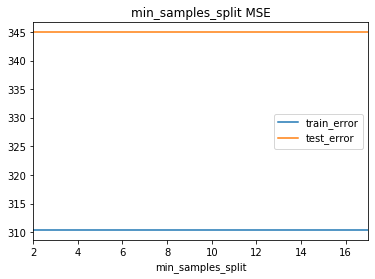

In [28]:
# gbr +maxdepth COMPLETE
# best min_samples_split=default                                                    ###
hyperp = 'min_samples_split'                                                 ###
list_val = range(2,20,3)

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(min_samples_split=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val, 
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

2
   min_samples_leaf  train_error  test_error
0                 2   350.378303  351.876126
12
   min_samples_leaf  train_error  test_error
0                 2   350.378303  351.876126
1                12   350.378303  351.876126
22
   min_samples_leaf  train_error  test_error
0                 2   350.378303  351.876126
1                12   350.378303  351.876126
2                22   350.378303  351.876126
32
   min_samples_leaf  train_error  test_error
0                 2   350.378303  351.876126
1                12   350.378303  351.876126
2                22   350.378303  351.876126
3                32   350.378303  351.876126
42
   min_samples_leaf  train_error  test_error
0                 2   350.378303  351.876126
1                12   350.378303  351.876126
2                22   350.378303  351.876126
3                32   350.378303  351.876126
4                42   350.378303  351.876126
52
   min_samples_leaf  train_error  test_error
0                 2   350.378303  351.

,train_error,test_error
min_samples_leaf,,
2,350.378303,351.876126
12,350.378303,351.876126
22,350.378303,351.876126
32,350.378303,351.876126
42,350.378303,351.876126
52,350.378303,351.876126
62,350.378303,351.876126
72,350.378303,351.876126
82,350.378303,351.876126


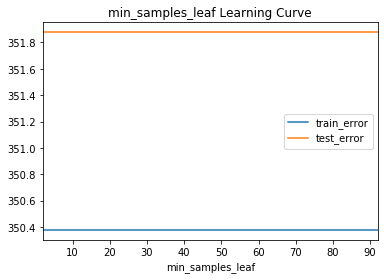

In [242]:
# COMPLETE
# best min_samples_leaf=exclude                                           ###
results = []
list_values = range(2,102,10)
hyperp = 'min_samples_leaf'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_samples_leaf=val, verbose=0, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_samples_leaf': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

   min_samples_leaf  train_error  test_error   minutes
0                 2   310.385331   344.92272  4.130574
   min_samples_leaf  train_error  test_error   minutes
0                 2   310.385331   344.92272  4.130574
1                 4   310.385331   344.92272  4.238295
   min_samples_leaf  train_error  test_error   minutes
0                 2   310.385331   344.92272  4.130574
1                 4   310.385331   344.92272  4.238295
2                 6   310.385331   344.92272  4.169426
   min_samples_leaf  train_error  test_error   minutes
0                 2   310.385331   344.92272  4.130574
1                 4   310.385331   344.92272  4.238295
2                 6   310.385331   344.92272  4.169426
3                 8   310.385331   344.92272  4.186108
   min_samples_leaf  train_error  test_error   minutes
0                 2   310.385331   344.92272  4.130574
1                 4   310.385331   344.92272  4.238295
2                 6   310.385331   344.92272  4.169426
3         

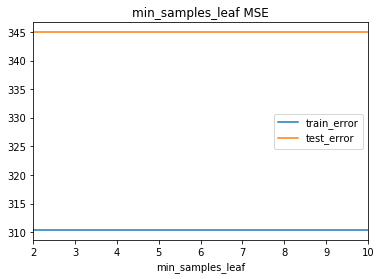

In [29]:
# gbr +maxdepth COMPLETE
# best min_samples_leaf=default                                                    ###
hyperp = 'min_samples_leaf'                                                 ###
list_val = range(2,12,2)

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(min_samples_leaf=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

1e-05
   min_weight_fraction_leaf  train_error  test_error
0                   0.00001   350.378303  351.876126
1e-06
   min_weight_fraction_leaf  train_error  test_error
0                  0.000010   350.378303  351.876126
1                  0.000001   350.378303  351.876126
1e-07
   min_weight_fraction_leaf  train_error  test_error
0              1.000000e-05   350.378303  351.876126
1              1.000000e-06   350.378303  351.876126
2              1.000000e-07   350.378303  351.876126
1e-08
   min_weight_fraction_leaf  train_error  test_error
0              1.000000e-05   350.378303  351.876126
1              1.000000e-06   350.378303  351.876126
2              1.000000e-07   350.378303  351.876126
3              1.000000e-08   350.378303  351.876126


,train_error,test_error
min_weight_fraction_leaf,,
1.000000e-08,350.378303,351.876126
1.000000e-07,350.378303,351.876126
1.000000e-06,350.378303,351.876126
1.000000e-05,350.378303,351.876126


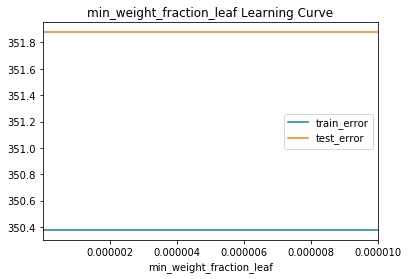

In [259]:
# COMPLETE
# best min_weight_fraction_leaf=Default                                          ###
results = []
list_values = [0,.1,.2,.3,.4,.5]
list_values = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
list_values = [1e-1,1e-2,1e-3,1e-4]
list_values = [1e-5,1e-6,1e-7,1e-8]

hyperp = 'min_weight_fraction_leaf'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_weight_fraction_leaf=val, verbose=0, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_weight_fraction_leaf': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

   min_weight_fraction_leaf  train_error  test_error   minutes
0                         0   310.385331   344.92272  4.116575
   min_weight_fraction_leaf  train_error  test_error   minutes
0                       0.0   310.385331   344.92272  4.116575
1                       0.1   310.385331   344.92272  4.081022
   min_weight_fraction_leaf  train_error  test_error   minutes
0                       0.0   310.385331   344.92272  4.116575
1                       0.1   310.385331   344.92272  4.081022
2                       0.2   310.385331   344.92272  4.146166
   min_weight_fraction_leaf  train_error  test_error   minutes
0                       0.0   310.385331   344.92272  4.116575
1                       0.1   310.385331   344.92272  4.081022
2                       0.2   310.385331   344.92272  4.146166
3                       0.3   310.385331   344.92272  4.860707
   min_weight_fraction_leaf  train_error  test_error   minutes
0                       0.0   310.385331   344.92272  4

NameError: name 'min_weight_fraction_leaf' is not defined

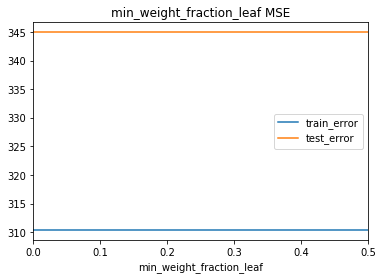

In [30]:
# gbr +maxdepth 
# best min_weight_fraction_leaf=default                                                    ###
hyperp = 'min_weight_fraction_leaf'                                                 ###
list_val = [0,.1,.2,.3,.4,.5]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(min_weight_fraction_leaf=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

      Iter       Train Loss   Remaining Time 
         1        1332.8022           57.19s
         2        1276.0416           48.65s
         3        1227.9670           48.12s
         4        1185.8246           43.22s
         5        1151.4026           39.93s
         6        1119.7158           37.49s
         7        1090.3077           36.48s
         8        1063.2558           35.16s
         9        1037.7124           34.24s
        10        1014.7813           33.36s
        20         836.8172           27.97s
        30         716.3855           25.37s
        40         630.8786           22.28s
        50         569.2047           18.02s
        60         523.3802           13.89s
        70         489.2453           10.39s
        80         463.2922            6.89s
        90         443.3241            3.41s
       100         427.9902            0.00s
1
   max_depth  train_error  test_error
0          1   427.990173  430.748842
      Iter       Trai

,train_error,test_error
max_depth,,
1,427.990173,430.748842
3,350.378303,351.876126
5,341.840545,343.303662
7,336.745896,338.352166
9,326.429460,327.888957


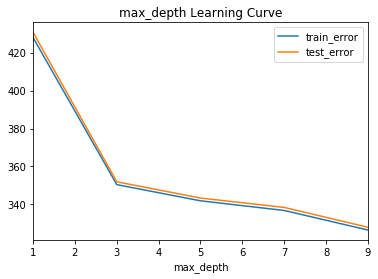

In [248]:
# COMPLETE
# best max_depth= [10,11,12]                                            ###
results = []
list_values = range(1,10,2)
hyperp = 'max_depth'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_depth=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_depth': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

      Iter       Train Loss   Remaining Time 
         1        1332.8022           34.11s
         2        1276.0416           33.35s
         3        1227.9670           34.41s
         4        1185.8246           34.32s
         5        1151.4026           33.37s
         6        1119.7158           32.84s
         7        1090.3077           32.14s
         8        1063.2558           31.37s
         9        1037.7124           31.11s
        10        1014.7813           30.76s
        20         836.8172           28.22s
        30         716.3855           24.79s
        40         630.8786           21.20s
        50         569.2047           17.59s
        60         523.3802           14.10s
        70         489.2453           11.02s
        80         463.2922            7.79s
        90         443.3241            3.95s
       100         427.9902            0.00s
1
   max_depth  train_error  test_error
0          1   427.990173  430.748842
      Iter       Trai

        40         341.4675           18.09m
        50         338.3060           14.56m
        60         336.4763           11.53m
        70         335.3060            8.50m
        80         334.4356            5.66m
        90         333.6176            2.80m
       100         332.7332            0.00s
8
   max_depth  train_error  test_error
0          1   427.990173  430.748842
1          2   357.177980  359.166687
2          3   350.378303  351.876126
3          4   345.954281  347.720999
4          5   341.840545  343.303662
5          6   339.005597  340.455242
6          7   336.745896  338.352166
7          8   332.733187  334.298912
      Iter       Train Loss   Remaining Time 
         1        1212.1864           47.37m
         2        1056.8392           46.29m
         3         930.0828           45.56m
         4         826.4579           46.20m
         5         741.5667           46.19m
         6         672.0294           46.35m
         7         614.88

,train_error,test_error
max_depth,,
1,427.990173,430.748842
2,357.177980,359.166687
3,350.378303,351.876126
4,345.954281,347.720999
5,341.840545,343.303662
6,339.005597,340.455242
7,336.745896,338.352166
8,332.733187,334.298912
9,326.429460,327.888957


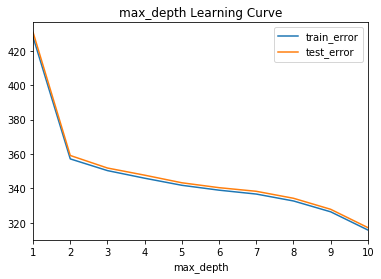

In [250]:
# best max_depth=                                             ###
results = []
list_values = range(1,11)
hyperp = 'max_depth'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_depth=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_depth': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

      Iter       Train Loss   Remaining Time 
         1        1206.2399          144.01m
         2        1046.4037          143.35m
         3         916.1987          142.33m
         4         810.2072          142.43m
         5         723.7139          141.68m
         6         653.2272          140.82m
         7         595.4932          139.55m
         8         548.3945          138.58m
         9         509.8804          137.50m
        10         478.2927          136.56m
        20         352.5089          120.99m
        30         330.1083          106.12m
        40         322.0791           89.74m
        50         317.0677           72.80m
        60         312.8242           56.86m
        70         308.5463           41.79m
        80         305.2706           27.34m
        90         301.9332           13.50m
       100         297.8915            0.00s
11
   max_depth  train_error  test_error
0         11   297.891493  299.099159
      Iter       Tra

,train_error,test_error
max_depth,,
11,297.891493,299.099159
12,273.930048,274.878911


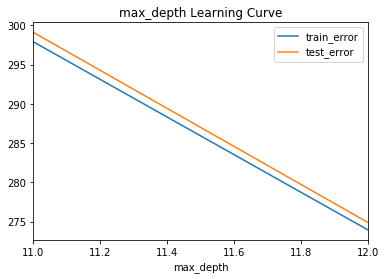

In [258]:
# best max_depth=                                             ###
results = []
list_values = range(11,13)
hyperp = 'max_depth'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_depth=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_depth': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# we need to determinne if the parameters we used for tuning were used in tuning our actual model...

   n_estimators  train_error  test_error   minutes
0            70   317.787807  344.464723  4.223812
   n_estimators  train_error  test_error   minutes
0            70   317.787807  344.464723  4.223812
1            71   317.430781  344.410705  4.809901
   n_estimators  train_error  test_error   minutes
0            70   317.787807  344.464723  4.223812
1            71   317.430781  344.410705  4.809901
2            72   317.166434  344.401609  4.879439
   n_estimators  train_error  test_error   minutes
0            70   317.787807  344.464723  4.223812
1            71   317.430781  344.410705  4.809901
2            72   317.166434  344.401609  4.879439
3            73   316.986560  344.408794  4.561127
   n_estimators  train_error  test_error   minutes
0            70   317.787807  344.464723  4.223812
1            71   317.430781  344.410705  4.809901
2            72   317.166434  344.401609  4.879439
3            73   316.986560  344.408794  4.561127
4            74   316.581514  3

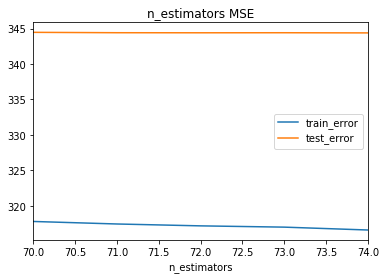

In [32]:
# gbr +maxdepth COMPLETE
# best n_estimators= [70,72,74]                                                   ###
hyperp = 'n_estimators'                                                 ###
list_val = range(70,75)

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(n_estimators=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

In [252]:
# COMPLETE
# best min_impurity_decrease= NA, same scores                                            ###
results = []
list_values = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
list_values = [1e-1,1e-2,1e-3,1e-4,1e-5]
hyperp = 'min_impurity_decrease'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_impurity_decrease=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_impurity_decrease': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

      Iter       Train Loss   Remaining Time 
         1        1276.3058            2.20m
         2        1172.8489            2.52m
         3        1083.1942            2.45m
         4        1010.2434            2.42m
         5         943.9434            2.36m
         6         887.7758            2.56m
         7         837.6927            2.61m
         8         793.4905            2.56m
         9         754.7839            2.50m
        10         721.2267            2.42m
        20         515.1608            2.01m
        30         429.7942            1.74m
        40         391.1022            1.44m
        50         371.8133            1.16m
        60         361.7795           54.77s
        70         356.6357           40.04s
        80         353.5098           26.12s
        90         351.6403           12.89s
       100         350.3783            0.00s
0.1
   min_impurity_decrease  train_error  test_error
0                    0.1   350.378303  351.87

KeyboardInterrupt: 

   min_impurity_decrease  train_error  test_error   minutes
0                      0   310.385331   344.92272  5.236923
   min_impurity_decrease  train_error  test_error   minutes
0                    0.0   310.385331   344.92272  5.236923
1                    0.1   310.385331   344.92272  4.171316
   min_impurity_decrease  train_error  test_error   minutes
0                    0.0   310.385331   344.92272  5.236923
1                    0.1   310.385331   344.92272  4.171316
2                    0.5   310.385331   344.92272  4.468565
   min_impurity_decrease  train_error  test_error   minutes
0                    0.0   310.385331   344.92272  5.236923
1                    0.1   310.385331   344.92272  4.171316
2                    0.5   310.385331   344.92272  4.468565
3                    0.7   310.385331   344.92272  5.881562
   min_impurity_decrease  train_error  test_error   minutes
0                    0.0   310.385331   344.92272  5.236923
1                    0.1   310.385331   

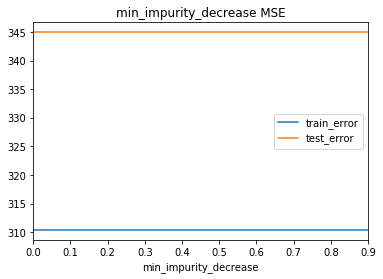

In [33]:
# gbr +maxdepth 
# best min_impurity_decrease=[0,.1] #improves time                                                    ###
hyperp = 'min_impurity_decrease'                                                 ###
list_val = [0,.1,.5,.7,.9]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(min_impurity_decrease=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

   min_impurity_decrease  train_error  test_error   minutes
0                   0.01   310.385331   344.92272  6.002544
   min_impurity_decrease  train_error  test_error   minutes
0                   0.01   310.385331   344.92272  6.002544
1                   0.03   310.385331   344.92272  4.998416
   min_impurity_decrease  train_error  test_error   minutes
0                   0.01   310.385331   344.92272  6.002544
1                   0.03   310.385331   344.92272  4.998416
2                   0.05   310.385331   344.92272  4.757570
   min_impurity_decrease  train_error  test_error   minutes
0                   0.01   310.385331   344.92272  6.002544
1                   0.03   310.385331   344.92272  4.998416
2                   0.05   310.385331   344.92272  4.757570
3                   0.07   310.385331   344.92272  5.337464
   min_impurity_decrease  train_error  test_error   minutes
0                   0.01   310.385331   344.92272  6.002544
1                   0.03   310.385331   

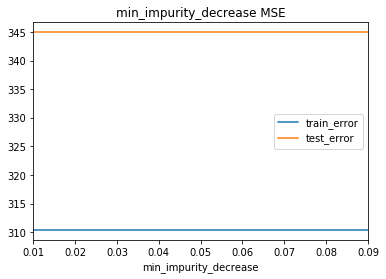

In [39]:
# gbr +maxdepth 
# best min_impurity_decrease=.1 #improves time                                                    ###
hyperp = 'min_impurity_decrease'                                                 ###
list_val = [.01,.03,.05,.07,.09]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(min_impurity_decrease=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

      Iter       Train Loss   Remaining Time 
         1        1276.3058            2.67m
         2        1172.8489            2.36m
         3        1083.1942            2.20m
         4        1010.2434            2.08m
         5         943.9434            2.20m
         6         887.7758            2.28m
         7         837.6927            2.21m
         8         793.4905            2.14m
         9         754.7839            2.10m
        10         721.2267            2.06m
        20         515.1608            1.73m
        30         429.7942            1.45m
        40         391.1022            1.22m
        50         371.8133            1.00m
        60         361.7795           47.79s
        70         356.6357           35.52s
        80         353.5098           23.50s
        90         351.6403           12.09s
       100         350.3783            0.00s
auto
  max_features  train_error  test_error
0         auto   350.378303  351.876126
      Iter    

,train_error,test_error
max_features,,
auto,350.378303,351.876126
log2,357.519186,359.239074
sqrt,356.128934,357.684683
NaN,350.378303,351.876126


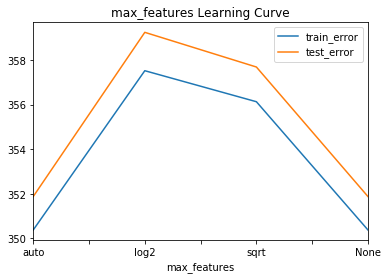

In [253]:
# COMPLETE
# best max_features= 'auto' default                                             ###
results = []
list_values = ['auto', 'sqrt', 'log2', None]
hyperp = 'max_features'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_features=val, verbose=1) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_features': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

  max_features  train_error  test_error   minutes
0         auto   310.385331   344.92272  6.155373
  max_features  train_error  test_error   minutes
0         auto   310.385331   344.92272  6.155373
1         sqrt   310.385331   344.92272  7.312433
  max_features  train_error  test_error   minutes
0         auto   310.385331   344.92272  6.155373
1         sqrt   310.385331   344.92272  7.312433
2         log2   310.385331   344.92272  6.450204
  max_features  train_error  test_error   minutes
0         auto   310.385331   344.92272  6.155373
1         sqrt   310.385331   344.92272  7.312433
2         log2   310.385331   344.92272  6.450204
3         None   310.385331   344.92272  4.938310


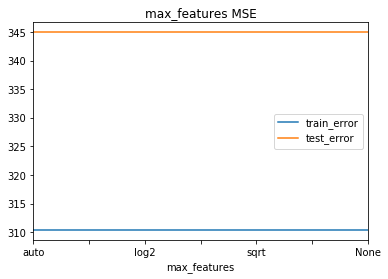

In [34]:
# gbr +maxdepth 
# best max_features=default                                                    ###
hyperp = 'max_features'                                                 ###
list_val = ['auto', 'sqrt', 'log2', None]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(max_features=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

      Iter       Train Loss   Remaining Time 
         1        1276.3058            2.62m
         2        1172.8489            2.92m
         3        1083.1942            3.47m
         4        1010.2434            3.35m
         5         943.9434            3.30m
         6         887.7758            3.10m
         7         837.6927            3.15m
         8         793.4905            3.12m
         9         754.7839            3.04m
        10         721.2267            2.89m
        20         515.1608            2.20m
        30         429.7942            1.81m
        40         391.1022            1.60m
        50         371.8133            1.33m
        60         361.7795            1.07m
        70         356.6357           47.29s
        80         353.5098           31.17s
        90         351.6403           15.55s
       100         350.3783            0.00s
0.1
   alpha  train_error  test_error
0    0.1   350.378303  351.876126
      Iter       Train Loss

,train_error,test_error
alpha,,
0.00001,350.378303,351.876126
0.00010,350.378303,351.876126
0.00100,350.378303,351.876126
0.01000,350.378303,351.876126
0.10000,350.378303,351.876126


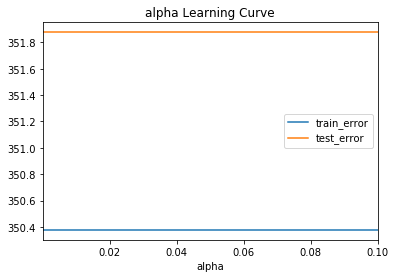

In [257]:
# COMPLETE 
# best alpha=default                                            ###
results = []
list_values = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
list_values = [1e-1,1e-2,1e-3,1e-4,1e-5]
hyperp = 'alpha'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(alpha=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'alpha': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

   alpha  train_error  test_error   minutes
0    0.1   310.588652  343.865901  4.292857
   alpha  train_error  test_error   minutes
0    0.1   310.588652  343.865901  4.292857
1    0.5   310.588652  343.865901  4.366690
   alpha  train_error  test_error    minutes
0    0.1   310.588652  343.865901   4.292857
1    0.5   310.588652  343.865901   4.366690
2    0.9   310.588652  343.865901  26.154097


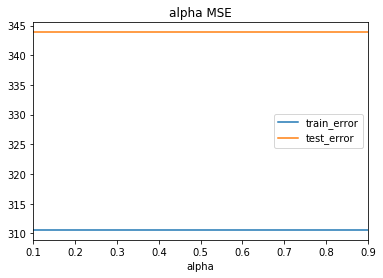

In [95]:
# gbr +maxdepth 
# best alpha=default                                                    ###
hyperp = 'alpha'                                                 ###
list_val = [.1,.5,.9]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(alpha=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

   alpha  train_error  test_error   minutes
0    0.1   310.588652  343.865901  4.622315
   alpha  train_error  test_error    minutes
0    0.1   310.588652  343.865901   4.622315
1    0.5   310.588652  343.865901  60.212593
   alpha  train_error  test_error    minutes
0    0.1   310.588652  343.865901   4.622315
1    0.5   310.588652  343.865901  60.212593
2    0.9   310.588652  343.865901  15.701073


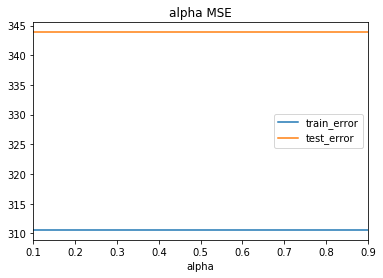

In [96]:
# gbr +maxdepth 
# best alpha=default                                                    ###
hyperp = 'alpha'                                                 ###
list_val = [.1,.5,.9]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(alpha=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

      Iter       Train Loss   Remaining Time 
         1        1286.5981            8.40m
         2        1191.7625            7.92m
         3        1106.4211            7.67m
         4        1038.1022            8.31m
         5         976.0772            8.69m
         6         923.7350            8.33m
         7         875.9393            8.14m
         8         833.3008            7.99m
         9         795.8143            7.80m
        10         760.3589            7.60m
        20         545.8243            7.64m
        30         448.7280            6.84m
        40         402.5519            5.38m
        50         378.7387            4.24m
        60         366.2344            3.34m
        70         359.5042            2.57m
        80         355.6470            1.60m
        90         353.1504           44.99s
       100         351.6064            0.00s
6
   max_leaf_nodes  train_error  test_error
0               6   351.606416  353.171406
      Iter 

,train_error,test_error
max_leaf_nodes,,
6,351.606416,353.171406
7,350.323302,351.973118
8,350.378303,351.876126
9,350.378303,351.876126
10,350.378303,351.876126


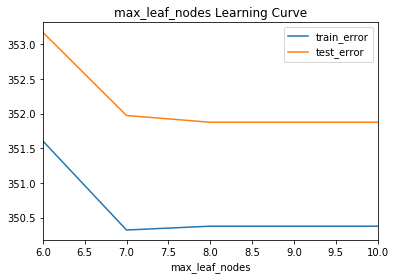

In [267]:
# best max_leaf_nodes= [6,7,8]                                           ###
results = []
list_values = ['None']
list_values = range(2,20,4) # 22 test error 351.876126
list_values = range(6,11)
hyperp = 'max_leaf_nodes'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_leaf_nodes=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_leaf_nodes': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

   max_leaf_nodes  train_error  test_error   minutes
0               1   310.385331   344.92272  4.281671
   max_leaf_nodes  train_error  test_error   minutes
0               1   310.385331   344.92272  4.281671
1               4   310.385331   344.92272  4.348840
   max_leaf_nodes  train_error  test_error   minutes
0               1   310.385331   344.92272  4.281671
1               4   310.385331   344.92272  4.348840
2               7   310.385331   344.92272  4.439776
   max_leaf_nodes  train_error  test_error   minutes
0               1   310.385331   344.92272  4.281671
1               4   310.385331   344.92272  4.348840
2               7   310.385331   344.92272  4.439776
3              10   310.385331   344.92272  4.255148
   max_leaf_nodes  train_error  test_error   minutes
0               1   310.385331   344.92272  4.281671
1               4   310.385331   344.92272  4.348840
2               7   310.385331   344.92272  4.439776
3              10   310.385331   344.92272  4.

NameError: name 'min_weight_fraction_leafmin_impurity_decreasealpha' is not defined

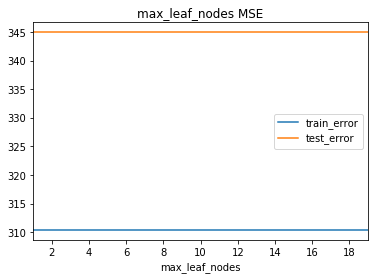

In [35]:
# gbr +maxdepth COMPLETE
# best max_leaf_nodes=default                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = range(1,20,3)

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(max_leaf_nodes=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

  max_leaf_nodes  train_error  test_error   minutes
0           None   310.385331   344.92272  4.799858


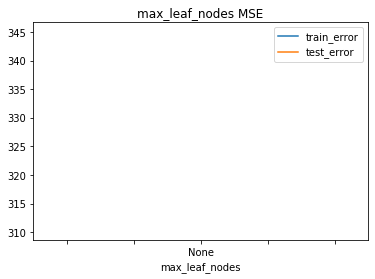

In [36]:
# gbr +maxdepth 
# best max_leaf_nodes=                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = [None]

results=[]
for val in list_val:
    start_time = time.time()
    gbr = GradientBoostingRegressor(max_leaf_nodes=val, max_depth=10,          ###
                                    random_state=42, verbose=0) 
    gbr.fit(X_train, y_train)
    results.append(
        {
            hyperp: val,                                         ###
            'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
            'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['train_error','test_error']].plot(title=hyperp + ' MSE');

In [ ]:
y_train2 = data.train_df.salary
X_train2 = data.train_df.drop(['jobId','salary'],axis=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished


,oob_score
max_depth,
8,0.603584
10,0.624578
12,0.638769
14,0.634440


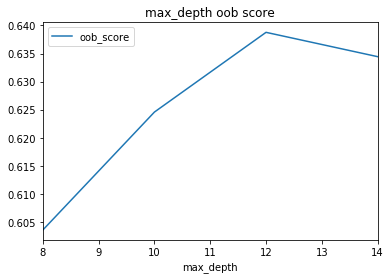

In [172]:
# best max_depth=
list_values = range(8,16,2)
hyperp = 'max_depth'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_depth=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished


,oob_score
max_depth,
10,0.627049
11,0.635253
12,0.638442
13,0.639957
14,0.633507
15,0.628921


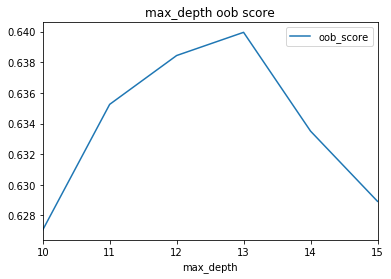

In [174]:
# best max_depth=13
list_values = range(10,16)
hyperp = 'max_depth'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_depth=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

In [44]:
# # best max_depth=13
# list_values = range(10,16)
# hyperp = 'max_depth'
# results = []
# for val in list_values:
#     rfr = RandomForestRegressor(max_depth=val, verbose=True, n_jobs=-1, oob_score=True)
#     rfr.fit(X_train, y_train) 
#     results.append(
#                    {hyperp: val,
#                     'oob_score': rfr.oob_score_,
#                   })
#     print(pd.DataFrame(results))
# results = pd.DataFrame(results).set_index(hyperp).sort_index()
# results.plot(title=hyperp + ' oob score')
# results

,oob_score
min_samples_split,
0.000219,0.641072
0.000220,0.640972
0.000221,0.640768
0.000222,0.636921
0.000223,0.641165
0.000224,0.640867
0.000225,0.640829
0.000226,0.639705
0.000227,0.640189


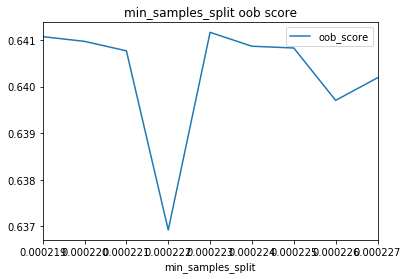

In [129]:
# best min_samples_split (<1) = 0.000223 score=0.641165
list_values = [1e-3,1e-4,1e-4,1e-5]
list_values = [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.002]
list_values = [.00019,.0002,.000211,.00022,.00023,.00024,.00025,.00026,.00027,.00028,.00029,.0003]
list_values = [.000211,.000212,.000213,.000214,.000215,.000216,.000217,.000218,.000219]
list_values = [.000219,.000220,.000221,.000222,.000223,.000224,.000225,.000226,.000227]
hyperp = 'min_samples_split'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_split=val, verbose=False, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

In [ ]:
# best min_samples_split (<1) = 0.000223 score=0.641165
list_values = [1e-3,1e-4,1e-4,1e-5]
list_values = [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001]
list_values = [.00019,.0002,.000211,.00022,.00023,.00024,.00025,.00026,.00027,.00028,.00029,.0003]
list_values = [.000211,.000212,.000213,.000214,.000215,.000216,.000217,.000218,.000219]
list_values = [.000219,.000220,.000221,.000222,.000223,.000224,.000225,.000226,.000227]
hyperp = 'min_samples_split'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_split=val, verbose=False, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score
min_samples_split,
175,0.641146
176,0.641715
177,0.640615
178,0.639274
179,0.639845
180,0.638809
181,0.639591
182,0.638856
183,0.638712


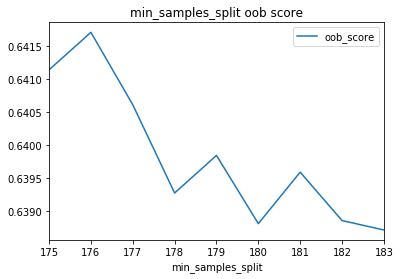

In [128]:
# best min_samples_split (>1) = 176 score=0.641715
# list_values = [50,100,150,200,25,300,350]
list_values = range(175,184)
hyperp = 'min_samples_split'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_split=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
                                    data.train_df.drop([col_target,col_id],axis=1), 
                                    data.train_df[col_target], test_size=0.25)
eval_set = [(X_train, y_train),(X_test, y_test)]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.9s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.8s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.2s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.9s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752
4                119   0.640125  0.332828


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.7s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752
4                119   0.640125  0.332828
5                120   0.639115  0.333254


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752
4                119   0.640125  0.332828
5                120   0.639115  0.333254
6                121   0.640647  0.376618


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.1s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752
4                119   0.640125  0.332828
5                120   0.639115  0.333254
6                121   0.640647  0.376618
7                122   0.638696  0.422890


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.2s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752
4                119   0.640125  0.332828
5                120   0.639115  0.333254
6                121   0.640647  0.376618
7                122   0.638696  0.422890
8                123   0.637140  0.373129


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished


   min_samples_split  oob_score   minutes
0                115   0.638327  0.403526
1                116   0.639467  0.334570
2                117   0.641615  0.356701
3                118   0.640293  0.339752
4                119   0.640125  0.332828
5                120   0.639115  0.333254
6                121   0.640647  0.376618
7                122   0.638696  0.422890
8                123   0.637140  0.373129
9                124   0.638350  0.325792


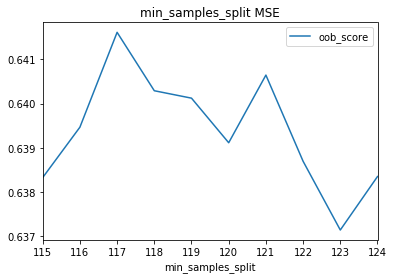

In [57]:
# rfr +maxdepth COMPLETE
# best min_samples_split=[115,117,119]                                                   ###
hyperp = 'min_samples_split'                                                 ###
list_val = range(115,125)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(min_samples_split=val, max_depth=13,     ###
                                verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         ###
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

,oob_score
min_samples_leaf,
74,0.642372
75,0.641522
76,0.642872
77,0.643692
78,0.642358
79,0.640394


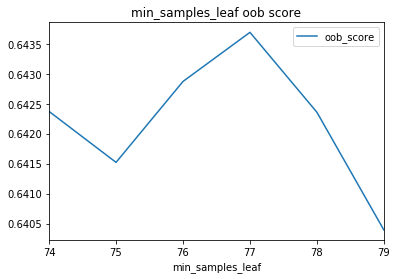

In [131]:
# best min_samples_leaf=77 76,77,78
list_values = range(74,80)
hyperp = 'min_samples_leaf'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_leaf=val, verbose=False, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.6s finished


   min_samples_leaf  oob_score   minutes
0                46   0.638523  0.308843


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished


   min_samples_leaf  oob_score   minutes
0                46   0.638523  0.308843
1                47   0.641272  0.327568


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.9s finished


   min_samples_leaf  oob_score   minutes
0                46   0.638523  0.308843
1                47   0.641272  0.327568
2                48   0.638552  0.332950


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished


   min_samples_leaf  oob_score   minutes
0                46   0.638523  0.308843
1                47   0.641272  0.327568
2                48   0.638552  0.332950
3                49   0.641036  0.322951


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.0s finished


   min_samples_leaf  oob_score   minutes
0                46   0.638523  0.308843
1                47   0.641272  0.327568
2                48   0.638552  0.332950
3                49   0.641036  0.322951
4                50   0.638765  0.387157


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.9s finished


   min_samples_leaf  oob_score   minutes
0                46   0.638523  0.308843
1                47   0.641272  0.327568
2                48   0.638552  0.332950
3                49   0.641036  0.322951
4                50   0.638765  0.387157
5                51   0.636216  0.350002


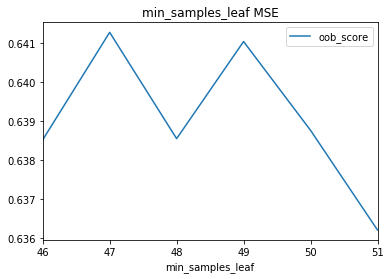

In [18]:
# rfr +maxdepth COMPLETE
# best min_samples_leaf=[47,48,49]                                                    ###
hyperp = 'min_samples_leaf'                                                 ###
list_val = [50,100,150,200,25,300,350]
list_val =  range(40,80,5)
list_val =  range(46,52)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(min_samples_leaf=val, max_depth=13,     ###
                                verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

,oob_score
min_weight_fraction_leaf,
0.000050,0.638117
0.000060,0.641142
0.000070,0.641720
0.000080,0.639702
0.000090,0.640280
0.000092,0.642510
0.000093,0.642216
0.000094,0.640562
0.000095,0.640457


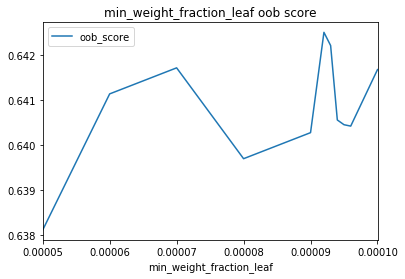

In [135]:
# best min_weight_fraction_leaf=0.000092
list_values = [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
list_values = [0, .00008,.00007,.00006,.00005,.00004,.00003,.00002,.00001]
list_values = [.00009,.000092,.000093,.000094,.000095,.000096,.0001]
hyperp = 'min_weight_fraction_leaf'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_weight_fraction_leaf=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.0s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.4s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.9s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.8s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868
3                    0.0004   0.636434  0.365083


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.3s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868
3                    0.0004   0.636434  0.365083
4                    0.0005   0.634104  0.337598


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.1s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868
3                    0.0004   0.636434  0.365083
4                    0.0005   0.634104  0.337598
5                    0.0006   0.632006  0.302085


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.6s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868
3                    0.0004   0.636434  0.365083
4                    0.0005   0.634104  0.337598
5                    0.0006   0.632006  0.302085
6                    0.0007   0.630060  0.292599


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.9s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868
3                    0.0004   0.636434  0.365083
4                    0.0005   0.634104  0.337598
5                    0.0006   0.632006  0.302085
6                    0.0007   0.630060  0.292599
7                    0.0008   0.628304  0.295575


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0001   0.641564  0.388227
1                    0.0002   0.640605  0.339909
2                    0.0003   0.638611  0.315868
3                    0.0004   0.636434  0.365083
4                    0.0005   0.634104  0.337598
5                    0.0006   0.632006  0.302085
6                    0.0007   0.630060  0.292599
7                    0.0008   0.628304  0.295575
8                    0.0009   0.626551  0.287035


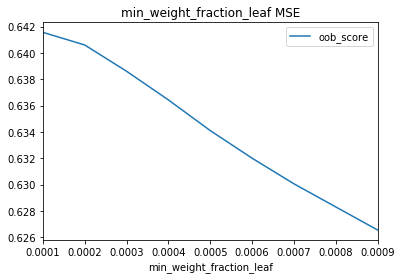

In [19]:
# rfr +maxdepth 
# best min_weight_fraction_leaf=                                                    ###
hyperp = 'min_weight_fraction_leaf'                                                 ###
list_val = [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]
list_val = [1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4]

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(min_weight_fraction_leaf=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished


   min_weight_fraction_leaf  oob_score   minutes
0                         0   0.638804  0.295452


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished


   min_weight_fraction_leaf  oob_score   minutes
0                       0.0   0.638804  0.295452
1                       0.1   0.359641  0.102148


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.1s finished


   min_weight_fraction_leaf  oob_score   minutes
0                      0.00   0.638804  0.295452
1                      0.10   0.359641  0.102148
2                      0.01   0.559745  0.213505


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.7s finished


   min_weight_fraction_leaf  oob_score   minutes
0                     0.000   0.638804  0.295452
1                     0.100   0.359641  0.102148
2                     0.010   0.559745  0.213505
3                     0.001   0.624811  0.278066


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.2s finished


   min_weight_fraction_leaf  oob_score   minutes
0                    0.0000   0.638804  0.295452
1                    0.1000   0.359641  0.102148
2                    0.0100   0.559745  0.213505
3                    0.0010   0.624811  0.278066
4                    0.0001   0.641564  0.286036


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s finished


   min_weight_fraction_leaf  oob_score   minutes
0                   0.00000   0.638804  0.295452
1                   0.10000   0.359641  0.102148
2                   0.01000   0.559745  0.213505
3                   0.00100   0.624811  0.278066
4                   0.00010   0.641564  0.286036
5                   0.00001   0.639140  0.270991


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.5s finished


   min_weight_fraction_leaf  oob_score   minutes
0                  0.000000   0.638804  0.295452
1                  0.100000   0.359641  0.102148
2                  0.010000   0.559745  0.213505
3                  0.001000   0.624811  0.278066
4                  0.000100   0.641564  0.286036
5                  0.000010   0.639140  0.270991
6                  0.000001   0.638804  0.275106


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.9s finished


   min_weight_fraction_leaf  oob_score   minutes
0              0.000000e+00   0.638804  0.295452
1              1.000000e-01   0.359641  0.102148
2              1.000000e-02   0.559745  0.213505
3              1.000000e-03   0.624811  0.278066
4              1.000000e-04   0.641564  0.286036
5              1.000000e-05   0.639140  0.270991
6              1.000000e-06   0.638804  0.275106
7              1.000000e-07   0.638804  0.350946


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.2s finished


   min_weight_fraction_leaf  oob_score   minutes
0              0.000000e+00   0.638804  0.295452
1              1.000000e-01   0.359641  0.102148
2              1.000000e-02   0.559745  0.213505
3              1.000000e-03   0.624811  0.278066
4              1.000000e-04   0.641564  0.286036
5              1.000000e-05   0.639140  0.270991
6              1.000000e-06   0.638804  0.275106
7              1.000000e-07   0.638804  0.350946
8              1.000000e-08   0.638804  0.342887


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.2s finished


   min_weight_fraction_leaf  oob_score   minutes
0              0.000000e+00   0.638804  0.295452
1              1.000000e-01   0.359641  0.102148
2              1.000000e-02   0.559745  0.213505
3              1.000000e-03   0.624811  0.278066
4              1.000000e-04   0.641564  0.286036
5              1.000000e-05   0.639140  0.270991
6              1.000000e-06   0.638804  0.275106
7              1.000000e-07   0.638804  0.350946
8              1.000000e-08   0.638804  0.342887
9              1.000000e-09   0.638804  0.302512


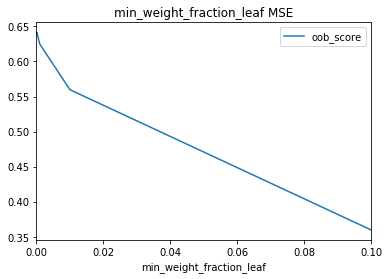

In [23]:
# rfr +maxdepth 
# best min_weight_fraction_leaf=                                                    ###
hyperp = 'min_weight_fraction_leaf'                                                 ###
list_val = [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]
# list_val = [1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4]

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(min_weight_fraction_leaf=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.5s finished


  max_features  oob_score   minutes
0         auto   0.638804  0.399437


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


  max_features  oob_score   minutes
0         auto   0.638804  0.399437
1         sqrt   0.629658  0.128941


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


  max_features  oob_score   minutes
0         auto   0.638804  0.399437
1         sqrt   0.629658  0.128941
2         log2   0.629658  0.119724


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished


  max_features  oob_score   minutes
0         auto   0.638804  0.399437
1         sqrt   0.629658  0.128941
2         log2   0.629658  0.119724
3         None   0.638804  0.344413


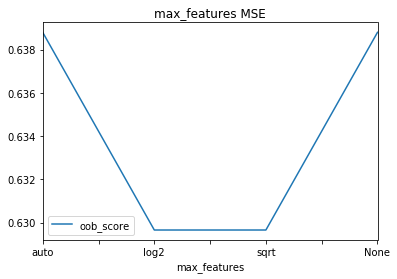

In [20]:
# rfr +maxdepth COMPLETE
# best max_features=default                                                    ###
hyperp = 'max_features'                                                 ###
list_val = ['auto', 'sqrt', 'log2', None]

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_features=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score
max_features,
0.40,0.551685
0.50,0.550201
0.51,0.551900
0.52,0.550538
0.53,0.551605
0.54,0.552517
0.55,0.548812
0.56,0.550548
0.57,0.552449


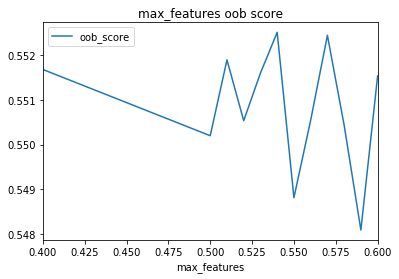

In [146]:
# best max_features='sqrt' score: 0.550349, or 0.54 score:0.552517
# list_values = [.4,.5,.51,.52,.53,.54,.55,.56,.57,.58,.59,.6]
# list_values = ['auto', 'sqrt', 'log2', None]
# list_values = ['sqrt']
hyperp = 'max_features'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_features=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.1s finished


   max_leaf_nodes  oob_score   minutes
0            1000    0.63068  0.320576


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.4s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.7s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.8s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.5s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067
4            9000   0.638819  0.373847


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.8s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067
4            9000   0.638819  0.373847
5           11000   0.638819  0.315068


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.7s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067
4            9000   0.638819  0.373847
5           11000   0.638819  0.315068
6           13000   0.638819  0.349816


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.4s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067
4            9000   0.638819  0.373847
5           11000   0.638819  0.315068
6           13000   0.638819  0.349816
7           15000   0.638819  0.394217


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067
4            9000   0.638819  0.373847
5           11000   0.638819  0.315068
6           13000   0.638819  0.349816
7           15000   0.638819  0.394217
8           17000   0.638819  0.381061


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.4s finished


   max_leaf_nodes  oob_score   minutes
0            1000   0.630680  0.320576
1            3000   0.639178  0.340581
2            5000   0.639427  0.410098
3            7000   0.639008  0.398067
4            9000   0.638819  0.373847
5           11000   0.638819  0.315068
6           13000   0.638819  0.349816
7           15000   0.638819  0.394217
8           17000   0.638819  0.381061
9           19000   0.638819  0.357999


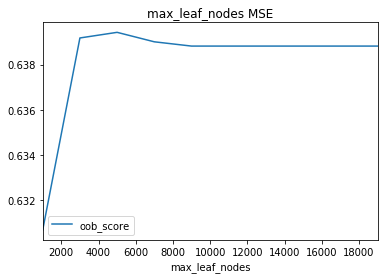

In [21]:
# rfr +maxdepth 
# best max_leaf_nodes=                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = range(1000,20000,2000)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_leaf_nodes=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score,minutes
max_depth,,
1,0.165830,0.062805
3,0.376325,0.125589
5,0.511048,0.139289
7,0.582137,0.194925
9,0.618352,0.231211
11,0.636040,0.249725
13,0.638804,0.326834
15,0.627249,0.318980
17,0.605461,0.386996


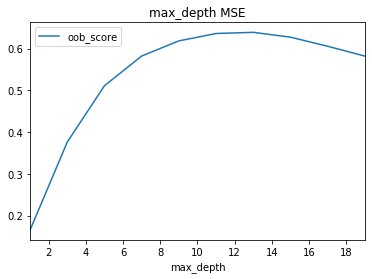

In [43]:
# rfr +maxdepth 
# best max_depth=[4340,4346,4350]                                                    ###
hyperp = 'max_depth'                                                 ###
list_val = range(1,20,2)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_depth=val,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
#     print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');
results
# max_depth 10 2002	0.629012

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.6s finished


,oob_score,minutes
max_leaf_nodes,,
1000,0.630680,0.488993
2000,0.637314,0.471964
3000,0.638551,0.386321
4000,0.638463,0.403132
5000,0.637853,0.360493


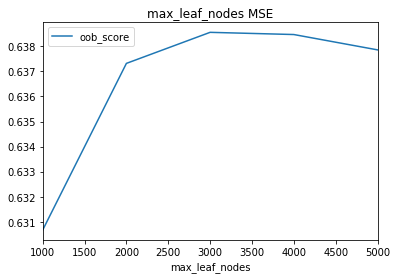

In [40]:
# rfr +maxdepth 
# best max_leaf_nodes=[4340,4346,4350]                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = range(1000,6000,1000)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_leaf_nodes=val, max_depth=16,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
#     print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');
results
# max_depth 10 2002	0.629012

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score,minutes
max_leaf_nodes,,
100,0.574987,0.229103
200,0.598539,0.243861
300,0.609243,0.223112
400,0.615584,0.245201
500,0.619824,0.239554
600,0.622863,0.239119
700,0.625135,0.309484
800,0.626848,0.322313
900,0.628133,0.297611


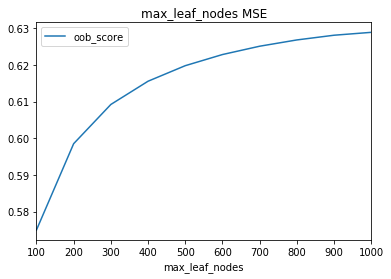

In [38]:
# rfr +maxdepth 
# best max_leaf_nodes=[4340,4346,4350]                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = range(100,1100,100)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_leaf_nodes=val, max_depth=10,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
#     print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

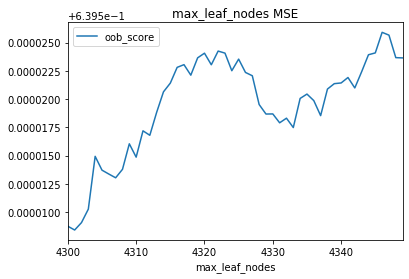

In [27]:
# rfr +maxdepth 
# best max_leaf_nodes=[4340,4346,4350]                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = range(4300,4350,1)

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_leaf_nodes=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
#     print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');
results

In [29]:
results

,oob_score,minutes
max_leaf_nodes,,
4300,0.639509,0.383482
4301,0.639508,0.343770
4302,0.639509,0.357436
4303,0.639510,0.357853
4304,0.639515,0.355150
4305,0.639514,0.346989
4306,0.639513,0.366635
4307,0.639513,0.386065
4308,0.639514,0.396263


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.2s finished


  max_leaf_nodes  oob_score   minutes
0           None   0.638804  0.253344


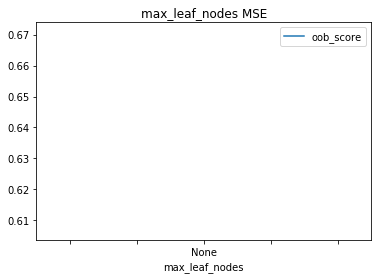

In [26]:
# rfr +maxdepth 
# best max_leaf_nodes=                                                    ###
hyperp = 'max_leaf_nodes'                                                 ###
list_val = [None]

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(max_leaf_nodes=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

In [34]:
# RFR Tuning REDO
param_grid = {"max_depth": [11,12,13],
              "min_samples_split": [115,117,119],
              'min_samples_leaf':[47,48,49],
              'max_leaf_nodes':[4340,4346,4350]
              }
model_rfr = RandomForestRegressor(random_state=42, verbose=1)
# Perform Grid Search CV
gs_cv_rfr = GridSearchCV(model_rfr, param_grid=param_grid, cv = 3, scoring='neg_mean_squared_error',
                     verbose=10, n_jobs=-1 ).fit(X_train, y_train)

print(gs_cv_rfr.best_estimator_)
gs_cv_rfr_df = pd.DataFrame(gs_cv_rfr.cv_results_)
gs_cv_rfr_df

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 30

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=4340,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=49, min_samples_split=115,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=1,
                      warm_start=False)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.3s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,38.919965,0.127914,0.631958,0.025334,11,4340,47,115,"{'max_depth': 11, 'max_leaf_nodes': 4340, 'min...",-360.312418,-360.743791,-362.351698,-361.135968,0.877503,64
1,38.782700,0.104185,0.703952,0.063741,11,4340,47,117,"{'max_depth': 11, 'max_leaf_nodes': 4340, 'min...",-360.333830,-360.750642,-362.358193,-361.147554,0.872799,73
2,38.653783,0.641786,0.685243,0.016728,11,4340,47,119,"{'max_depth': 11, 'max_leaf_nodes': 4340, 'min...",-360.340563,-360.754543,-362.367902,-361.154335,0.874605,79
3,37.916414,0.186255,0.801925,0.052717,11,4340,48,115,"{'max_depth': 11, 'max_leaf_nodes': 4340, 'min...",-360.320133,-360.751251,-362.320567,-361.130649,0.859609,58
4,38.013977,0.063647,0.615502,0.098275,11,4340,48,117,"{'max_depth': 11, 'max_leaf_nodes': 4340, 'min...",-360.341998,-360.756758,-362.327210,-361.141988,0.855012,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,42.881935,0.274340,0.897813,0.069317,13,4350,48,117,"{'max_depth': 13, 'max_leaf_nodes': 4350, 'min...",-354.632712,-354.709792,-355.983531,-355.108678,0.619414,13
77,42.553381,0.639290,0.955555,0.169297,13,4350,48,119,"{'max_depth': 13, 'max_leaf_nodes': 4350, 'min...",-354.683693,-354.736327,-356.005540,-355.141853,0.611097,22
78,42.055586,0.149607,0.848943,0.012896,13,4350,49,115,"{'max_depth': 13, 'max_leaf_nodes': 4350, 'min...",-354.566789,-354.655232,-355.927102,-355.049707,0.621461,1
79,42.323171,0.204569,0.866938,0.027809,13,4350,49,117,"{'max_depth': 13, 'max_leaf_nodes': 4350, 'min...",-354.618696,-354.693610,-355.956787,-355.089697,0.613887,10


In [71]:
# NEXT, rerun rfr then store into dataframe
gs_cv_rfr_df.to_csv('gs_cv_rfr.csv')

NameError: name 'gs_cv_rfr_df' is not defined

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
                                    data.train_df.drop([col_target,col_id],axis=1), 
                                    data.train_df[col_target], test_size=0.25)
eval_set = [(X_train, y_train),(X_test, y_test)]

In [55]:
best_model_xgbr_test = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bynode=1, colsample_bytree=1, gamma=0,
                             importance_type='gain', learning_rate=0.01, max_delta_step=0,
                             max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
                             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, tree_method='hist', verbosity=1)


In [62]:
best_model_xgbr_test.fit(X_train, y_train, early_stopping_rounds=10,eval_set=eval_set, verbose=True)
# Best early stopping at 1275

[09:52:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:119.45	validation_1-rmse:119.493
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:118.293	validation_1-rmse:118.346
[2]	validation_0-rmse:117.158	validation_1-rmse:117.206
[3]	validation_0-rmse:116.031	validation_1-rmse:116.074
[4]	validation_0-rmse:114.905	validation_1-rmse:114.96
[5]	validation_0-rmse:113.801	validation_1-rmse:113.857
[6]	validation_0-rmse:112.708	validation_1-rmse:112.758
[7]	validation_0-rmse:111.622	validation_1-rmse:111.675
[8]	validation_0-rmse:110.554	validation_1-rmse:110.603
[9]	validation_0-rmse:109.496	validation_1-rmse:109.542
[10]	validation_0-rmse:108.446	validation_1-rmse:108.492
[11]	validation_0-rmse:107.405	validation_1-rmse:107.453
[12]	validation_0-rmse:106.373	validation_1-rmse:106.

[139]	validation_0-rmse:35.4652	validation_1-rmse:35.5036
[140]	validation_0-rmse:35.2192	validation_1-rmse:35.2576
[141]	validation_0-rmse:34.9759	validation_1-rmse:35.0146
[142]	validation_0-rmse:34.7363	validation_1-rmse:34.7751
[143]	validation_0-rmse:34.4991	validation_1-rmse:34.538
[144]	validation_0-rmse:34.2653	validation_1-rmse:34.3045
[145]	validation_0-rmse:34.0342	validation_1-rmse:34.0731
[146]	validation_0-rmse:33.8066	validation_1-rmse:33.8456
[147]	validation_0-rmse:33.5817	validation_1-rmse:33.6205
[148]	validation_0-rmse:33.3595	validation_1-rmse:33.3988
[149]	validation_0-rmse:33.1399	validation_1-rmse:33.1791
[150]	validation_0-rmse:32.9235	validation_1-rmse:32.963
[151]	validation_0-rmse:32.7103	validation_1-rmse:32.7498
[152]	validation_0-rmse:32.4992	validation_1-rmse:32.5387
[153]	validation_0-rmse:32.2909	validation_1-rmse:32.3309
[154]	validation_0-rmse:32.0854	validation_1-rmse:32.1253
[155]	validation_0-rmse:31.8828	validation_1-rmse:31.9228
[156]	validation

[281]	validation_0-rmse:20.2504	validation_1-rmse:20.3002
[282]	validation_0-rmse:20.2223	validation_1-rmse:20.272
[283]	validation_0-rmse:20.1941	validation_1-rmse:20.2443
[284]	validation_0-rmse:20.1667	validation_1-rmse:20.2168
[285]	validation_0-rmse:20.1397	validation_1-rmse:20.1901
[286]	validation_0-rmse:20.113	validation_1-rmse:20.1636
[287]	validation_0-rmse:20.087	validation_1-rmse:20.1375
[288]	validation_0-rmse:20.0616	validation_1-rmse:20.1121
[289]	validation_0-rmse:20.0362	validation_1-rmse:20.087
[290]	validation_0-rmse:20.0115	validation_1-rmse:20.0623
[291]	validation_0-rmse:19.9864	validation_1-rmse:20.0375
[292]	validation_0-rmse:19.9625	validation_1-rmse:20.0137
[293]	validation_0-rmse:19.9379	validation_1-rmse:19.9889
[294]	validation_0-rmse:19.9148	validation_1-rmse:19.9661
[295]	validation_0-rmse:19.8922	validation_1-rmse:19.9434
[296]	validation_0-rmse:19.87	validation_1-rmse:19.9212
[297]	validation_0-rmse:19.8468	validation_1-rmse:19.8979
[298]	validation_0-r

[423]	validation_0-rmse:18.6788	validation_1-rmse:18.741
[424]	validation_0-rmse:18.6757	validation_1-rmse:18.7379
[425]	validation_0-rmse:18.6731	validation_1-rmse:18.7354
[426]	validation_0-rmse:18.67	validation_1-rmse:18.7324
[427]	validation_0-rmse:18.6675	validation_1-rmse:18.73
[428]	validation_0-rmse:18.6648	validation_1-rmse:18.7276
[429]	validation_0-rmse:18.6611	validation_1-rmse:18.7238
[430]	validation_0-rmse:18.6585	validation_1-rmse:18.7214
[431]	validation_0-rmse:18.6561	validation_1-rmse:18.7192
[432]	validation_0-rmse:18.6538	validation_1-rmse:18.7169
[433]	validation_0-rmse:18.6514	validation_1-rmse:18.7145
[434]	validation_0-rmse:18.6488	validation_1-rmse:18.712
[435]	validation_0-rmse:18.6467	validation_1-rmse:18.7099
[436]	validation_0-rmse:18.6443	validation_1-rmse:18.7076
[437]	validation_0-rmse:18.6406	validation_1-rmse:18.7041
[438]	validation_0-rmse:18.6386	validation_1-rmse:18.702
[439]	validation_0-rmse:18.6364	validation_1-rmse:18.7
[440]	validation_0-rmse:

[566]	validation_0-rmse:18.494	validation_1-rmse:18.5657
[567]	validation_0-rmse:18.4935	validation_1-rmse:18.5651
[568]	validation_0-rmse:18.493	validation_1-rmse:18.5648
[569]	validation_0-rmse:18.4925	validation_1-rmse:18.5643
[570]	validation_0-rmse:18.4921	validation_1-rmse:18.564
[571]	validation_0-rmse:18.4913	validation_1-rmse:18.5633
[572]	validation_0-rmse:18.4907	validation_1-rmse:18.5627
[573]	validation_0-rmse:18.4899	validation_1-rmse:18.562
[574]	validation_0-rmse:18.4895	validation_1-rmse:18.5617
[575]	validation_0-rmse:18.4881	validation_1-rmse:18.5605
[576]	validation_0-rmse:18.4876	validation_1-rmse:18.5599
[577]	validation_0-rmse:18.4873	validation_1-rmse:18.5596
[578]	validation_0-rmse:18.4869	validation_1-rmse:18.5593
[579]	validation_0-rmse:18.4865	validation_1-rmse:18.559
[580]	validation_0-rmse:18.486	validation_1-rmse:18.5585
[581]	validation_0-rmse:18.4855	validation_1-rmse:18.5581
[582]	validation_0-rmse:18.4852	validation_1-rmse:18.5578
[583]	validation_0-r

[708]	validation_0-rmse:18.4381	validation_1-rmse:18.5174
[709]	validation_0-rmse:18.4379	validation_1-rmse:18.5174
[710]	validation_0-rmse:18.4369	validation_1-rmse:18.5163
[711]	validation_0-rmse:18.4367	validation_1-rmse:18.5162
[712]	validation_0-rmse:18.4366	validation_1-rmse:18.5161
[713]	validation_0-rmse:18.4364	validation_1-rmse:18.5161
[714]	validation_0-rmse:18.4362	validation_1-rmse:18.516
[715]	validation_0-rmse:18.4359	validation_1-rmse:18.5157
[716]	validation_0-rmse:18.4358	validation_1-rmse:18.5156
[717]	validation_0-rmse:18.4355	validation_1-rmse:18.5154
[718]	validation_0-rmse:18.4354	validation_1-rmse:18.5153
[719]	validation_0-rmse:18.4352	validation_1-rmse:18.5152
[720]	validation_0-rmse:18.435	validation_1-rmse:18.515
[721]	validation_0-rmse:18.4347	validation_1-rmse:18.5148
[722]	validation_0-rmse:18.4346	validation_1-rmse:18.5147
[723]	validation_0-rmse:18.4343	validation_1-rmse:18.5145
[724]	validation_0-rmse:18.4332	validation_1-rmse:18.5135
[725]	validation_

[850]	validation_0-rmse:18.407	validation_1-rmse:18.4949
[851]	validation_0-rmse:18.4068	validation_1-rmse:18.4948
[852]	validation_0-rmse:18.4066	validation_1-rmse:18.4946
[853]	validation_0-rmse:18.4065	validation_1-rmse:18.4945
[854]	validation_0-rmse:18.4064	validation_1-rmse:18.4945
[855]	validation_0-rmse:18.4063	validation_1-rmse:18.4944
[856]	validation_0-rmse:18.4061	validation_1-rmse:18.4942
[857]	validation_0-rmse:18.4057	validation_1-rmse:18.494
[858]	validation_0-rmse:18.4057	validation_1-rmse:18.494
[859]	validation_0-rmse:18.4056	validation_1-rmse:18.494
[860]	validation_0-rmse:18.4054	validation_1-rmse:18.4939
[861]	validation_0-rmse:18.4054	validation_1-rmse:18.4938
[862]	validation_0-rmse:18.4051	validation_1-rmse:18.4936
[863]	validation_0-rmse:18.405	validation_1-rmse:18.4937
[864]	validation_0-rmse:18.4049	validation_1-rmse:18.4936
[865]	validation_0-rmse:18.4047	validation_1-rmse:18.4934
[866]	validation_0-rmse:18.4047	validation_1-rmse:18.4934
[867]	validation_0-

[992]	validation_0-rmse:18.3878	validation_1-rmse:18.4832
[993]	validation_0-rmse:18.3877	validation_1-rmse:18.4832
[994]	validation_0-rmse:18.3876	validation_1-rmse:18.4831
[995]	validation_0-rmse:18.3875	validation_1-rmse:18.483
[996]	validation_0-rmse:18.3874	validation_1-rmse:18.483
[997]	validation_0-rmse:18.3873	validation_1-rmse:18.483
[998]	validation_0-rmse:18.3872	validation_1-rmse:18.483
[999]	validation_0-rmse:18.3871	validation_1-rmse:18.4829
[1000]	validation_0-rmse:18.3866	validation_1-rmse:18.4824
[1001]	validation_0-rmse:18.3865	validation_1-rmse:18.4823
[1002]	validation_0-rmse:18.3864	validation_1-rmse:18.4823
[1003]	validation_0-rmse:18.3863	validation_1-rmse:18.4823
[1004]	validation_0-rmse:18.3862	validation_1-rmse:18.4822
[1005]	validation_0-rmse:18.3861	validation_1-rmse:18.4822
[1006]	validation_0-rmse:18.3856	validation_1-rmse:18.4817
[1007]	validation_0-rmse:18.3855	validation_1-rmse:18.4816
[1008]	validation_0-rmse:18.3854	validation_1-rmse:18.4816
[1009]	va

[1132]	validation_0-rmse:18.3708	validation_1-rmse:18.474
[1133]	validation_0-rmse:18.3708	validation_1-rmse:18.474
[1134]	validation_0-rmse:18.3707	validation_1-rmse:18.474
[1135]	validation_0-rmse:18.3707	validation_1-rmse:18.474
[1136]	validation_0-rmse:18.3706	validation_1-rmse:18.474
[1137]	validation_0-rmse:18.3705	validation_1-rmse:18.4739
[1138]	validation_0-rmse:18.3703	validation_1-rmse:18.4737
[1139]	validation_0-rmse:18.3702	validation_1-rmse:18.4737
[1140]	validation_0-rmse:18.3701	validation_1-rmse:18.4736
[1141]	validation_0-rmse:18.37	validation_1-rmse:18.4736
[1142]	validation_0-rmse:18.3699	validation_1-rmse:18.4736
[1143]	validation_0-rmse:18.3698	validation_1-rmse:18.4736
[1144]	validation_0-rmse:18.3697	validation_1-rmse:18.4735
[1145]	validation_0-rmse:18.3697	validation_1-rmse:18.4735
[1146]	validation_0-rmse:18.3696	validation_1-rmse:18.4735
[1147]	validation_0-rmse:18.3695	validation_1-rmse:18.4735
[1148]	validation_0-rmse:18.3694	validation_1-rmse:18.4734
[114

[1272]	validation_0-rmse:18.3594	validation_1-rmse:18.471
[1273]	validation_0-rmse:18.3593	validation_1-rmse:18.471
[1274]	validation_0-rmse:18.3593	validation_1-rmse:18.4709
[1275]	validation_0-rmse:18.3592	validation_1-rmse:18.4709
[1276]	validation_0-rmse:18.3591	validation_1-rmse:18.4709
[1277]	validation_0-rmse:18.3591	validation_1-rmse:18.4709
[1278]	validation_0-rmse:18.359	validation_1-rmse:18.4709
[1279]	validation_0-rmse:18.3589	validation_1-rmse:18.4709
[1280]	validation_0-rmse:18.3589	validation_1-rmse:18.4709
[1281]	validation_0-rmse:18.3588	validation_1-rmse:18.4709
[1282]	validation_0-rmse:18.3587	validation_1-rmse:18.4709
[1283]	validation_0-rmse:18.3586	validation_1-rmse:18.4709
[1284]	validation_0-rmse:18.3586	validation_1-rmse:18.471
[1285]	validation_0-rmse:18.3585	validation_1-rmse:18.471
Stopping. Best iteration:
[1275]	validation_0-rmse:18.3592	validation_1-rmse:18.4709



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='hist', verbosity=1)

In [72]:
# XGBR Testing saving and loading model. 
best_model_xgbr_test

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='hist', verbosity=1)

In [82]:
best_model_xgbr_test.predict(X_train)

array([142.86887,  95.2914 , 149.58066, ...,  95.56278, 136.27155,
        46.33832], dtype=float32)

In [77]:
# calc best score MSE
(best_model_xgbr_test.best_score)*(best_model_xgbr_test.best_score)

341.17252137273607

In [78]:
# Saving model, NEXT, make into public method...
model._save_model(best_model_xgbr_test, 'temp_test_xgbr', True)

The model has been saved.


In [93]:
# Loading model, predicting, then calculating MSE. 
# NEXT, Save to specific folder, then load all saved models. Set everything up to save all 
# best models, then load them from a specific folder. Then predict on all of them. Put 
# this into some kind of folder/model. 

trained_xgbr_model = joblib.load(
    '/Users/krahman/work/salarypredictionportfolio/temp_test_xgbr')
y_test_pred = trained_xgbr_model.predict(X_test)
mean_squared_error(y_test_pred, y_test)

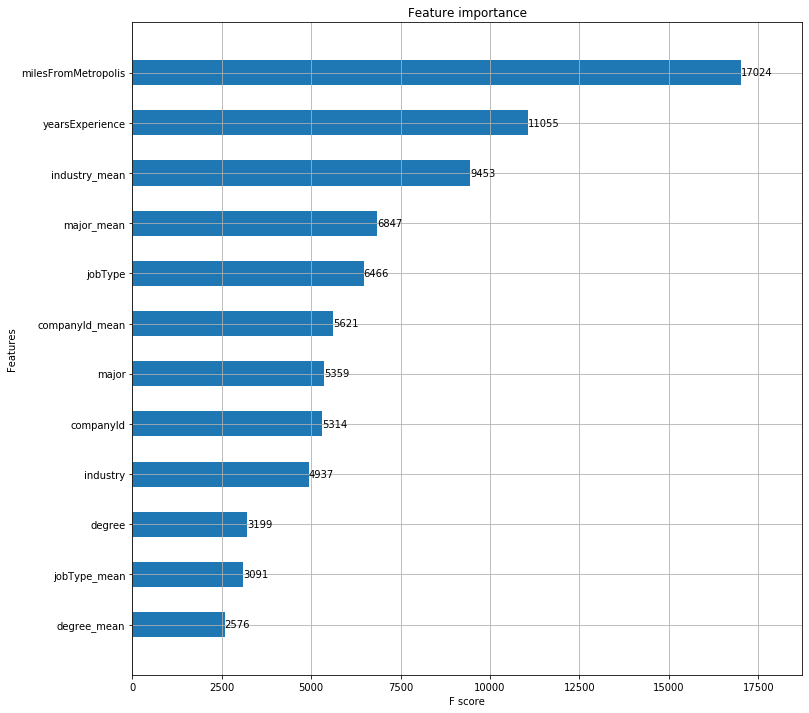

In [66]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(best_model_xgbr_test, height=.5, ax=ax)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.7s finished


,oob_score
max_leaf_nodes,
5117,0.637586
5118,0.639838
5119,0.638655
5120,0.638173
5121,0.637005


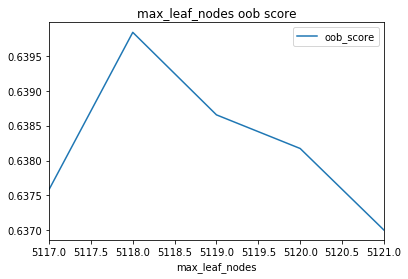

In [168]:
# best max_leaf_nodes= 5118
list_values = [5,25,50,75,100,125,150,175,200,None]
list_values = range(1000,20000,2000)
list_values = range(5117,5122)
hyperp = 'max_leaf_nodes'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_leaf_nodes=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished


   min_impurity_decrease  oob_score   minutes
0                      0   0.638804  0.333258


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.5s finished


   min_impurity_decrease  oob_score   minutes
0                    0.0   0.638804  0.333258
1                    0.1   0.612195  0.254778


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.5s finished


   min_impurity_decrease  oob_score   minutes
0                   0.00   0.638804  0.333258
1                   0.10   0.612195  0.254778
2                   0.01   0.638619  0.324318


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished


   min_impurity_decrease  oob_score   minutes
0                  0.000   0.638804  0.333258
1                  0.100   0.612195  0.254778
2                  0.010   0.638619  0.324318
3                  0.001   0.638857  0.344346


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.8s finished


   min_impurity_decrease  oob_score   minutes
0                 0.0000   0.638804  0.333258
1                 0.1000   0.612195  0.254778
2                 0.0100   0.638619  0.324318
3                 0.0010   0.638857  0.344346
4                 0.0001   0.638810  0.329650


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.0s finished


   min_impurity_decrease  oob_score   minutes
0                0.00000   0.638804  0.333258
1                0.10000   0.612195  0.254778
2                0.01000   0.638619  0.324318
3                0.00100   0.638857  0.344346
4                0.00010   0.638810  0.329650
5                0.00001   0.638806  0.283668


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.4s finished


   min_impurity_decrease  oob_score   minutes
0               0.000000   0.638804  0.333258
1               0.100000   0.612195  0.254778
2               0.010000   0.638619  0.324318
3               0.001000   0.638857  0.344346
4               0.000100   0.638810  0.329650
5               0.000010   0.638806  0.283668
6               0.000001   0.638804  0.357637


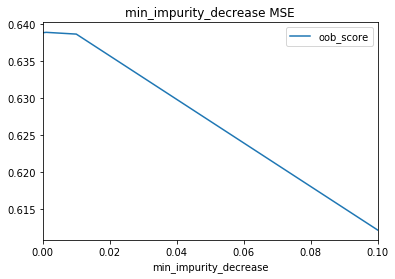

In [22]:
# rfr +maxdepth 
# best min_impurity_decrease=default                                                    ###
hyperp = 'min_impurity_decrease'                                                 ###
list_val = [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]

results=[]
for val in list_val:
    start_time = time.time()
    rfr = RandomForestRegressor(min_impurity_decrease=val, max_depth=13,     ###
                                verbose=True, random_state=42, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
        {
            hyperp: val,                                         
            'oob_score': rfr.oob_score_,
            'minutes': (time.time() - start_time)/60
        })
    print(pd.DataFrame(results))
    
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results[['oob_score']].plot(title=hyperp + ' MSE');

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score
min_impurity_decrease,
0.0089,0.637334
0.0090,0.636676
0.0091,0.639488
0.0092,0.637855
0.0093,0.638629
0.0094,0.639240
0.0095,0.637630
0.0096,0.637786
0.0097,0.636051


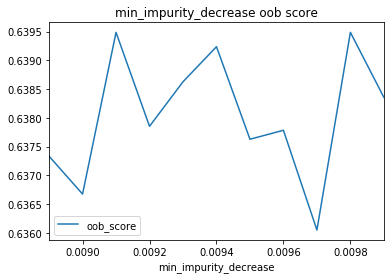

In [183]:
# min_impurity_decrease = 0.0098
list_values = [0,1e-1,1e-2]
# list_values = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]
list_values = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]
list_values = [0,.001,.002,.003,.004,.005,.006,.007,.008,.009]
list_values = [.0089,.0090,.0091,.0092,.0093,.0094,.0095,.0096,.0097,.0098,.0099]

hyperp = 'min_impurity_decrease'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_impurity_decrease=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
print(results.max())
results

In [282]:
#### FINAL RFR MODEL ####
# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
#                       max_features='auto', max_leaf_nodes=5117,
#                       min_impurity_decrease=0.0098, min_impurity_split=None,
#                       min_samples_leaf=77, min_samples_split=177,
#                       min_weight_fraction_leaf=9.2e-05, n_estimators=35,
#                       n_jobs=None, oob_score=False, random_state=None,
#                       verbose=0, warm_start=False)

y_train = data.train_df[col_target]
X_train = data.train_df.drop([col_target,col_id],axis=1)
print(y_train.shape)
print(X_train.shape)
rfr = RandomForestRegressor()

n_estimators = [34,35,36]
max_depth = [12,13,14]
min_samples_split = [175,176,177]
min_samples_leaf = [76,77,78]
min_weight_fraction_leaf = [0.000092, 0.000093, 0.000094]
max_features = ['sqrt','auto']
max_leaf_nodes = [5117,5118,5119]
min_impurity_decrease = [0.0097,0.0098,0.0099]

hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfr, hyperparameters, random_state=42, 
                         scoring='neg_mean_squared_error', cv=4, verbose=1, n_jobs=-1)
best_model2 = clf.fit(X_train, y_train)

print('Best n_estimators:', best_model2.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model2.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model2.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model2.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model2.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model2.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model2.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model2.best_estimator_.get_params()['min_impurity_decrease'])

(992418,)
(992418, 12)
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 25.3min finished


Best n_estimators: 35
Best max_depth: 14
Best min_samples_split: 177
Best min_samples_leaf: 77
Best min_weight_fraction_leaf: 9.2e-05
Best max_features: auto
Best max_leaf_nodes: 5117
Best min_impurity_decrease: 0.0098


In [283]:
best_model2.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=5117,
                      min_impurity_decrease=0.0098, min_impurity_split=None,
                      min_samples_leaf=77, min_samples_split=177,
                      min_weight_fraction_leaf=9.2e-05, n_estimators=35,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [284]:
# rfr RandomizedSearchCV
pd.DataFrame(best_model2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,260.123771,0.992019,2.189170,0.083075,36,9.3e-05,177,77,0.0098,5117,auto,12,"{'n_estimators': 36, 'min_weight_fraction_leaf...",-358.717716,-357.489325,-356.510939,-358.881614,-357.899899,0.965708,2
1,270.646933,1.347415,2.861222,0.334168,35,9.2e-05,177,77,0.0098,5117,auto,14,"{'n_estimators': 35, 'min_weight_fraction_leaf...",-357.291816,-355.898908,-354.937748,-357.482325,-356.402700,1.043552,1
2,79.982202,0.410818,1.848274,0.038614,36,9.3e-05,176,76,0.0099,5117,sqrt,14,"{'n_estimators': 36, 'min_weight_fraction_leaf...",-382.000562,-379.251961,-379.199350,-380.573636,-380.256378,1.147715,4
3,86.242328,0.224479,1.925088,0.186304,35,9.4e-05,175,78,0.0099,5118,sqrt,12,"{'n_estimators': 35, 'min_weight_fraction_leaf...",-382.772874,-381.257684,-384.844795,-382.509478,-382.846206,1.288072,10
4,77.038296,0.625002,2.762007,0.368028,34,9.4e-05,176,77,0.0097,5119,sqrt,14,"{'n_estimators': 34, 'min_weight_fraction_leaf...",-381.919305,-383.388785,-382.908110,-380.101944,-382.079537,1.258690,8
5,82.404504,0.023684,1.816866,0.479219,34,9.3e-05,176,76,0.0097,5118,sqrt,14,"{'n_estimators': 34, 'min_weight_fraction_leaf...",-382.576065,-382.519395,-381.754882,-380.613184,-381.865883,0.792624,7
6,97.430646,0.572842,2.274393,0.292186,34,9.3e-05,175,76,0.0097,5117,sqrt,14,"{'n_estimators': 34, 'min_weight_fraction_leaf...",-383.448110,-379.477801,-381.626043,-379.052503,-380.901115,1.764646,5
7,95.298529,0.574759,2.436320,0.072232,35,9.3e-05,177,77,0.0098,5117,sqrt,12,"{'n_estimators': 35, 'min_weight_fraction_leaf...",-383.726384,-380.792078,-382.827628,-379.777290,-381.780846,1.571048,6
8,99.710573,0.427635,2.501630,0.225479,36,9.2e-05,176,78,0.0099,5117,sqrt,13,"{'n_estimators': 36, 'min_weight_fraction_leaf...",-383.644712,-381.960278,-379.926277,-382.907850,-382.109780,1.394898,9
9,338.923353,2.066210,1.901752,0.392567,35,9.3e-05,176,77,0.0097,5117,auto,12,"{'n_estimators': 35, 'min_weight_fraction_leaf...",-359.021508,-357.444602,-356.413304,-359.047416,-357.981708,1.114146,3


In [274]:
y_train = data.train_df[col_target]
X_train = data.train_df.drop([col_target,col_id],axis=1)
print(y_train.shape)
print(X_train.shape)
rfr = RandomForestRegressor()

n_estimators = [34,35,36]
max_depth = [12,13,14]
min_samples_split = [175,176,177]
min_samples_leaf = [76,77,78]
min_weight_fraction_leaf = [0.000092, 0.000093, 0.000094]
max_features = ['sqrt','auto']
max_leaf_nodes = [5117,5118,5119]
min_impurity_decrease = [0.0097,0.0098,0.0099]

hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfr, hyperparameters, random_state=42, cv=3, verbose=1, n_jobs=-1)
best_model = clf.fit(X_train, y_train)


(992418,)
(992418, 12)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.0min finished


In [276]:
# best hyper parameters
# CV 3
# NEXT, get scores for this model 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])

Best n_estimators: 35
Best max_depth: 14
Best min_samples_split: 177
Best min_samples_leaf: 77
Best min_weight_fraction_leaf: 9.2e-05
Best max_features: auto
Best max_leaf_nodes: 5117
Best min_impurity_decrease: 0.0098


In [18]:
X_train, X_test, y_train, y_test = tuning_rfr.train_test_split(data.train_df)

### Add model, score, select best model, create prediction file and print summary

In [14]:
import time

In [ ]:
# NEXT, where did we go wrong wtih XGBR? 
XGBRegressor max_depth=10 TUNED
496.2026
14.4969
XGBRegressor max_depth=12 
353.66
3.42
XGBRegressor max_depth =13 TUNED
546.34
19.36
xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
                             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
                             importance_type='gain', learning_rate=0.65, max_delta_step=0,
                             max_depth=13, min_child_weight=1, missing=None, n_estimators=1000,
                             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
XGBRegressor max_depth = 13
358.92
3.5
XGBRegressor max_depth=13 n_estimators=100
450.86

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# we did great with GBR
GBR max depth=11 TUNED # When tuned, GBR performs much faster and has better score
344.79
1.88
GBR max_depth=11 TUNED
344.7956
2.0108
GBR max_depth=13
365.33
297.9174m
GBR max depth=11 
350.53
80.69

RFR 
357.11
1.03

In [ ]:
#### randomizedgridsearch GBR READY ####
##### GBR fit test #####
y_train = data.train_df[col_target]
X_train = data.train_df.drop([col_target,col_id],axis=1)
gbr = GradientBoostingRegressor()
learning_rate= [.5,.6,.7]
n_estimators= [110,111,112]
subsample= [.83,.84,.85]
max_depth= [10,11,12]
max_leaf_nodes= [6,7,8]
hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators,
                       subsample=subsample, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes
                      )
clf = RandomizedSearchCV(gbr, hyperparameters, random_state=42, cv=3, verbose=1, n_jobs=-1)
best_model = clf.fit(X_train, y_train)
# best hyper parameters
print('Best Penalty:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best Penalty:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best Penalty:', best_model.best_estimator_.get_params()['subsample'])
print('Best Penalty:', best_model.best_estimator_.get_params()['max_depth'])
print('Best Penalty:', best_model.best_estimator_.get_params()['max_leaf_nodes'])

start_time = time.time()
elapsed_time = time.time() - start_time
elapsed_time


In [42]:
# GBR GridSearchCV
# Split set for tuning
X_train, X_test, y_train, y_test = train_test_split(data.train_df.drop([col_target,col_id],axis=1), 
                                                    data.train_df[col_target], test_size=0.25)

max_depth=[10,11,12]
n_estimators= [70,72,74]
loss=['ls','huber','quantile']
learning_rate=[.05,.07,.09]
min_impurity_decrease=[0,.1]

# Define Parameters
param_grid = {"max_depth": [10,11,12],
              "n_estimators": [70,72,74],
              'loss':['ls','huber','quantile'],
              "learning_rate": [.05,.07,.09],
              'min_impurity_decrease':[0,.1]
              }
model_gbr = GradientBoostingRegressor()
# Perform Grid Search CV
gs_cv_gbr = GridSearchCV(model_gbr, param_grid=param_grid, cv = 3, scoring='neg_mean_squared_error',
                     verbose=10, n_jobs=-1 ).fit(X_train, y_train)

print(gs_cv_gbr.best_estimator_)
pd.DataFrame(gs_cv_gbr.cv_results_)

NameError: name 'GridSearchCV' is not defined

In [321]:
# start_time = time.time()
# model.add_model(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
#                                       max_features='auto', max_leaf_nodes=5117,
#                                       min_impurity_decrease=0.0098, min_impurity_split=None,
#                                       min_samples_leaf=77, min_samples_split=177,
#                                       min_weight_fraction_leaf=9.2e-05, n_estimators=35,
#                                       n_jobs=-1, oob_score=False, random_state=42,
#                                       verbose=1, warm_start=False)
                                    )
# print((time.time() - start_time)/60)
# print('minutes')

# start_time = time.time()
# model.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
#                              colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
#                              importance_type='gain', learning_rate=0.65, max_delta_step=0,
#                              max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
#                              n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
#                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#                              silent=None, subsample=1, verbosity=1)
#                             )
                
# print((time.time() - start_time)/60)
# print('minutes')

start_time = time.time()
model.add_model(xgb.XGBRegressor(max_depth=10, n_jobs=-1, nthread=-1, random_state=42, verbosity=1))
print((time.time() - start_time)/60)
print('minutes xgbr max depth')

# start_time = time.time()
# model.add_model(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
#                                           learning_rate=0.7, loss='ls', max_depth=11,
#                                           max_features=None, max_leaf_nodes=8,
#                                           min_impurity_decrease=0.0, min_impurity_split=None,
#                                           min_samples_leaf=1, min_samples_split=2,
#                                           min_weight_fraction_leaf=0.0, n_estimators=112,
#                                           n_iter_no_change=None, presort='auto',
#                                           random_state=42, subsample=0.85, tol=0.0001,
#                                           validation_fraction=0.1, verbose=1, warm_start=False)
#                                          )
# print((time.time() - start_time)/60)
# print('minutes ') 


# start_time = time.time()
# model.add_model(GradientBoostingRegressor(max_depth=13,random_state=42, verbose=1))
# print((time.time() - start_time)/60)
# print('minutes gbr max depth') 

selected_model = model.best_scoring_model(model_container)
pred_result = model.predict_model(selected_model, test_features,
                                  train_features, train_target, save_best_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.65, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score: 496.20264164557756 

14.496925298372904
minutes
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=N

In [323]:
start_time = time.time()
model.add_model(xgb.XGBRegressor(max_depth=10, n_jobs=-1, nthread=-1, random_state=42, verbosity=1))
print((time.time() - start_time)/60)
print('minutes xgbr max depth')

selected_model = model.best_scoring_model(model_container)
pred_result = model.predict_model(selected_model, test_features,
                                  train_features, train_target, save_best_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score: 345.9588442199989 

3.513104033470154
minutes xgbr max depth
The best model is:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.7, loss='ls', max_depth=11,
                          max_features=None, max_leaf_nodes=8,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=112,
   

In [322]:
start_time = time.time()
model.add_model(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                                      max_features='auto', max_leaf_nodes=5117,
                                      min_impurity_decrease=0.0098, min_impurity_split=None,
                                      min_samples_leaf=77, min_samples_split=177,
                                      min_weight_fraction_leaf=9.2e-05, n_estimators=35,
                                      n_jobs=-1, oob_score=False, random_state=42,
                                      verbose=1, warm_start=False)
                                    )
print((time.time() - start_time)/60)
print('minutes')

start_time = time.time()
# XGB increased max depth from 10 to 13
model.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
                             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
                             importance_type='gain', learning_rate=0.65, max_delta_step=0,
                             max_depth=13, min_child_weight=1, missing=None, n_estimators=1000,
                             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
                            )
                
print((time.time() - start_time)/60)
print('minutes - xgbr max depth 10 to 13 with other tuned parameters')

start_time = time.time()
model.add_model(xgb.XGBRegressor(max_depth=13, n_jobs=-1, nthread=-1, random_state=42, verbosity=1))
print((time.time() - start_time)/60)
print('minutes xgbr max depth 13')

start_time = time.time()
model.add_model(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                                          learning_rate=0.7, loss='ls', max_depth=11,
                                          max_features=None, max_leaf_nodes=8,
                                          min_impurity_decrease=0.0, min_impurity_split=None,
                                          min_samples_leaf=1, min_samples_split=2,
                                          min_weight_fraction_leaf=0.0, n_estimators=112,
                                          n_iter_no_change=None, presort='auto',
                                          random_state=42, subsample=0.85, tol=0.0001,
                                          validation_fraction=0.1, verbose=1, warm_start=False)
                                         )
print((time.time() - start_time)/60)
print('minutes gbr max depth 11 and tuned hyperp') 


start_time = time.time()
# reducted gbr from 13 to 11
model.add_model(GradientBoostingRegressor(max_depth=11,random_state=42, verbose=1))
print((time.time() - start_time)/60)
print('minutes gbr max depth 11 and default hyperp') 

selected_model = model.best_scoring_model(model_container)
pred_result = model.predict_model(selected_model, test_features,
                                  train_features, train_target, save_best_model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=5117,
                      min_impurity_decrease=0.0098, min_impurity_split=None,
                      min_samples_leaf=77, min_samples_split=177,
                      min_weight_fraction_leaf=9.2e-05, n_estimators=35,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                      warm_start=False)
score: 357.1114718312353 

1.031239398320516
minutes
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.65, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, 

In [324]:
model.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
                             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
                             importance_type='gain', learning_rate=0.65, max_delta_step=0,
                             max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
                             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
                            )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.65, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score: 450.8686777853818 



In [326]:
start_time = time.time()
model.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
                             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
                             importance_type='gain', learning_rate=0.1, max_delta_step=0,
                             max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
                             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
                            )
print((time.time() - start_time)/60)
print('minutes xgbr max depth 13 n_est 100 learning rate .1 ')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score: 349.8732145349122 

3.053715479373932
minutes xgbr n_est 100 learning rate .1 


In [15]:
start_time = time.time()
model.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
                             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
                             importance_type='gain', learning_rate=0.1, max_delta_step=0,
                             max_depth=13, min_child_weight=1, missing=None, n_estimators=1000,
                             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
                            )
print((time.time() - start_time)/60)
print('minutes xgbr max depth 13 n_est 1000 learning rate .1 ')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score: 399.11768379714465 

37.308843688170114
minutes xgbr max depth 13 n_est 1000 learning rate .1 


In [ ]:
start_time = time.time()
model.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
                             colsample_bynode=0.8, colsample_bytree=0.55, gamma=0,
                             importance_type='gain', learning_rate=0.1, max_delta_step=0,
                             max_depth=13, min_child_weight=1, missing=None, n_estimators=1000,
                             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                             silent=None, subsample=1, verbosity=1)
                            )
print((time.time() - start_time)/60)
print('minutes xgbr max depth 13 n_est 1000 learning rate .1 ')

### Load best model and create prediction


Loading saved best model...


/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)



 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Feature Importances
                 feature     score
0          jobType_mean  0.403004
1       yearsExperience  0.181435
2   milesFromMetropolis  0.125192
3         industry_mean  0.116661
4           degree_mean  0.070938
5            major_mean  0.062944
6               jobType  0.033245
7              industry  0.002198
8                degree  

AttributeError: 'Rectangle' object has no property 'fontsize'

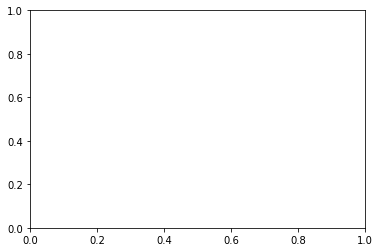

In [25]:
best_model_loaded = model.load_model(load_best_model, test_features)
# best_model_loaded

### EDA

In [ ]:
# delete once finished
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [ ]:
class Heatmap:
    def __init__(self, train_df, target_df, title):
        '''merge training and target df'''
        self.df = self._merge_df(train_df, target_df)
        self.col = self.df.columns
        self.target = col_target
        self.heatmap = self._create_corr_df(self.df, self.col, self.target, title)

    def _merge_df(self, df, target):
        '''merging training and target dataframes''' 
        return pd.merge(left=target, right=df, on=col_id, how='inner')

    def _create_corr_df(self, df, col, target, title):
        '''creates correlation matrix from train_df'''
        corr = df[self.col].corr()
        self._create_heatmap(corr)
        self._set_title(title)
        
    def _create_heatmap(self, corr):
        '''creates heatmap from correlation matrix'''
        plt.figure(figsize=(4,3))
        return sns.heatmap(corr, xticklabels=corr.columns.values, 
                           yticklabels=corr.columns.values, cmap='Blues', annot=True)
        
    def _set_title(self, title):
        '''sets title of correlation matrix'''
        plt.title(title)

In [ ]:
class Boxplot:
    def __init__(self, train_eda, target):
        '''create train and target dataframes'''
        self.df = train_eda
        self.target = target
        
    def create_boxplot(self, val, title):
        '''create boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(self.df, self.target, val)
        sns.boxplot(val, self.target, data=self.df, width=.3, color='#eeefff', order=col_avgs)
        
    def create_dual_boxplot(self, col1, val1, val2, col2, title):
        '''create dual axis boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(self.df, self.target, col2)
        df = self._create_dataframe(self.df, self.target, col1, val1, val2, col2)
        sns.boxplot(x=col2, y=self.target, hue=col1, data=df, palette='Set3', order=col_avgs)
    
    def _create_dataframe(self, df, target, col1, val1, val2, col3):
        '''create dataframe for dual boxplot'''
        return df[(df[col1]==val1) | (df[col1]==val2)].sort_values(self.target, ascending=True)
    
    def _calc_averages(self, df, target, val):
        '''calculate mean values'''
        df = self.df[[val, target]].groupby(val).mean().sort_values(target, ascending=True).reset_index()
        return df[val].values
    
    def _create_subplot(self):
        '''create subplot'''
        plt.subplots(figsize=(12,6.5))
        
    def _set_title(self, title):
        '''create title'''
        plt.title(title)

In [ ]:
sns.pairplot(data.train_eda)

KeyboardInterrupt: 

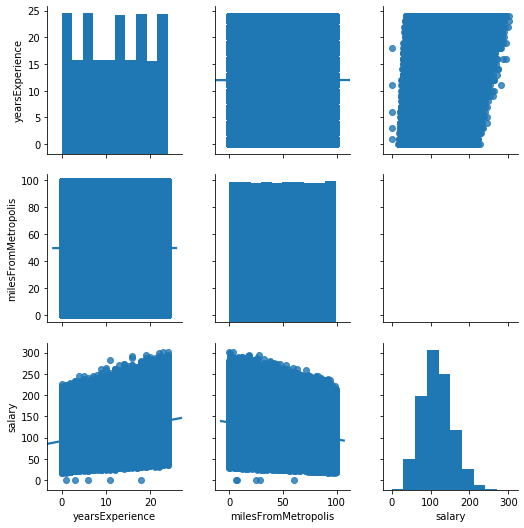

In [26]:
sns.pairplot(data.train_eda, kind='reg')

### Instantiate Boxplot and Heatmap objects

In [ ]:
bp = Boxplot(data.train_eda, col_target)
Heatmap(train_features_df, train_target_df, 'Heatmap of Correlation Matrix');

In [ ]:
bp.create_dual_boxplot('degree', 'HIGH_SCHOOL', 'NONE', 'jobType', 'Salary Versus Position & Degree')

In [ ]:
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [ ]:
train_features_df.head()

In [19]:
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [20]:
test_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [21]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [22]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [23]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [24]:
train_features_sum = train_features_df.duplicated().sum()
train_target_sum = train_target_df.duplicated().sum()
test_features_sum = test_features_df.duplicated().sum()
columns = train_features_df.columns
print('Train features duplicates: {}\nTrain target duplicates: {} \nTest features duplicates: {}\n'.format(train_features_sum, train_target_sum, test_features_sum))
print('Train feature columns:\n', list(columns))

Train features duplicates: 0
Train target duplicates: 0 
Test features duplicates: 0

Train feature columns:
 ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']


In [25]:
col_num = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
col_cat = ['yearsExperience', 'milesFromMetropolis']
col_id = 'jobId'

In [26]:
train_features_df.describe(include = np.number)

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [27]:
train_features_df.describe(include = np.object)

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684802051,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [28]:
train_df = pd.merge(train_features_df, train_target_df, on=col_id)
train_target = train_target_df

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [30]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


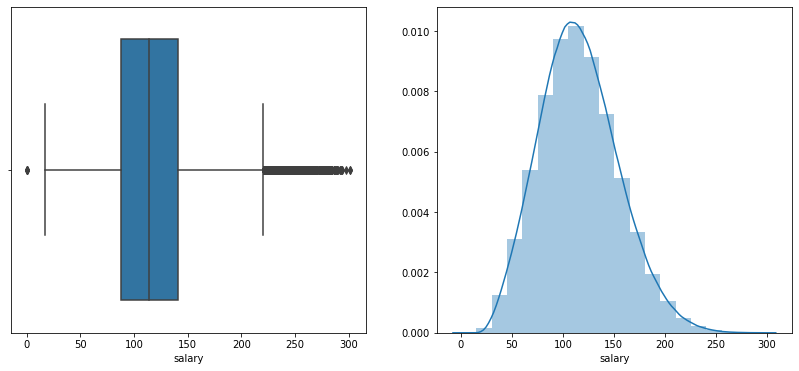

The upper and lower bounds for potential outliers are 220.5 and 8.5.


In [31]:
class TargetVisualization:
    def __init__(self, train_eda, target):
        '''create train and target dataframe'''
        self.df = train_eda
        self.target = target
        self._create_plots()
        self._calculate_iqr()
        
    def _create_plots(self):
        '''create boxplot and distplot'''
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        sns.boxplot(self.df[self.target])
        plt.subplot(1,2,2)
        sns.distplot(self.df[self.target], bins=20)
        plt.show()
        
    def _calculate_iqr(self):
        '''calculate iqr'''
        stat = self.df[self.target].describe()
        IQR = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * IQR
        lower = stat['25%'] - 1.5 * IQR
        print('The upper and lower bounds for potential outliers are {} and {}.'.format(upper,lower))

tv = TargetVisualization(data.train_eda, data.col_target)

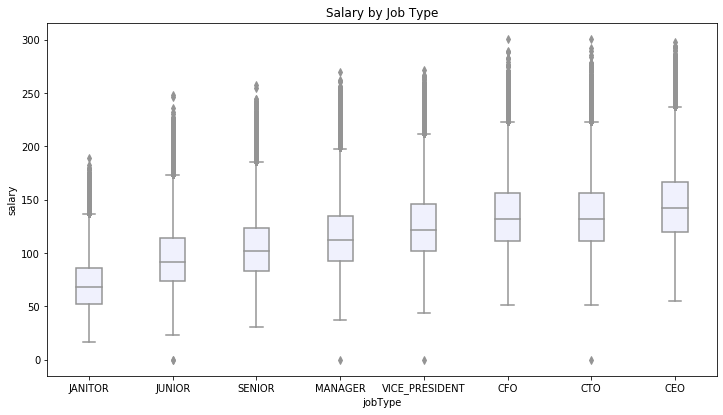

In [33]:
bp.create_boxplot('jobType', 'Salary by Job Type')

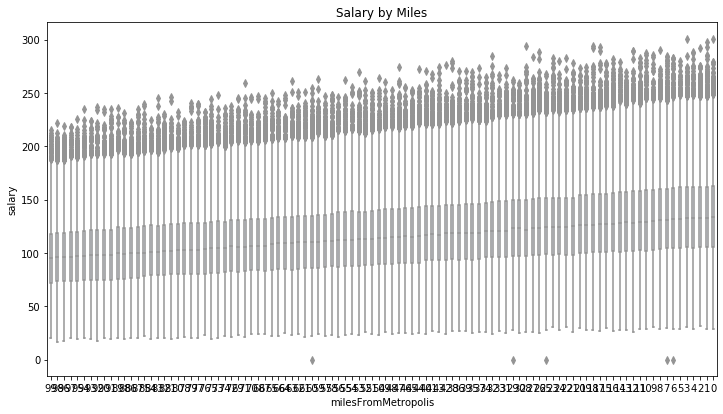

In [34]:
bp.create_boxplot('milesFromMetropolis', 'Salary by Miles')

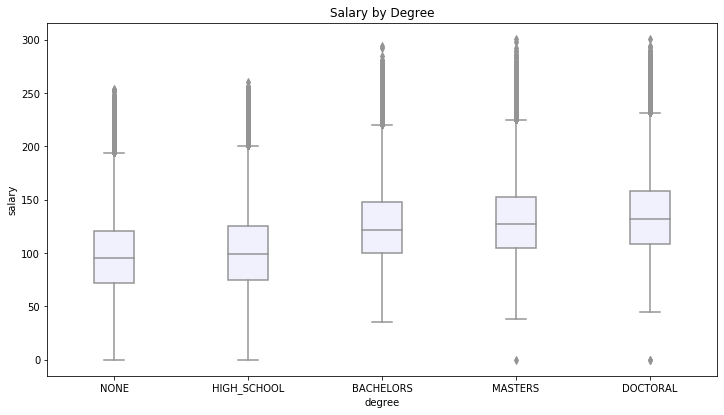

In [35]:
bp.create_boxplot('degree', 'Salary by Degree')

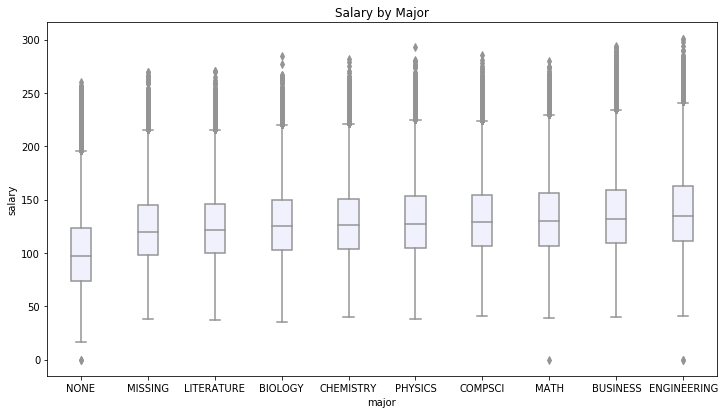

In [36]:
bp.create_boxplot('major', 'Salary by Major')

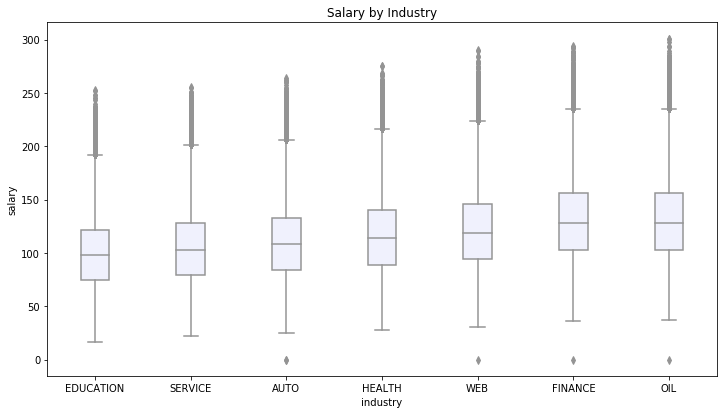

In [37]:
bp.create_boxplot('industry', 'Salary by Industry')

### ---- 11 Automate pipeline ----

In [38]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset